# Computing venusquake detection probabilities from a balloon platform
The code computes the probability of observing a signal with SNR > threshold at a given location or along a balloon trajectory for a variety of seismicity scenarios.

## Building detection maps

### Venusquakes: Rayleigh wave infrasound

In [2]:
import proba_modules as pm
from importlib import reload
reload(pm)

file_slopes = '../../../Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_curve = './test_data_Venus/GF_reverse_fault_1Hz_c15km.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min = 100., plot=False)

file_ratio = './test_data_Venus/surface_ratios_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

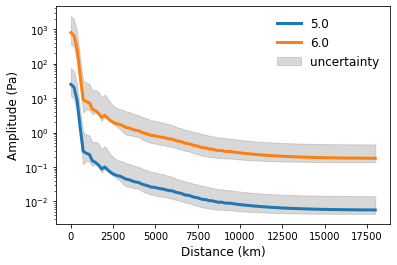

In [27]:
reload(pm)
file_curve = './test_data_Venus/GF_reverse_fault_1Hz_c15km.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min=100., use_savgol_filter=True, plot=True)

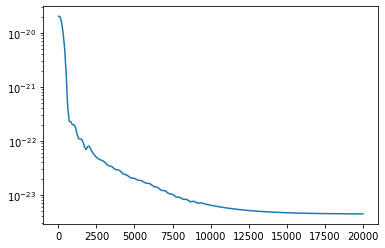

In [26]:
import numpy as np
import pandas as pd
from obspy.geodetics import degrees2kilometers
import matplotlib.pyplot as plt

pd_all_amps = pd.read_csv(file_curve, header=[0])
    
x, y = degrees2kilometers(pd_all_amps.dist.values), pd_all_amps.median_rw.values
    
from scipy.signal import savgol_filter
isep = np.argmin(abs(x-2000))
y_smooth = np.zeros_like(y)
window_size = 5  # Must be odd
poly_order = 3
y_smooth[:isep] = savgol_filter(y[:isep], window_size, poly_order)
window_size = 15  # Must be odd
poly_order = 3
y_smooth[isep:] = savgol_filter(y[isep:], window_size, poly_order)

plt.figure()
#plt.plot(x, y)
plt.plot(x, y_smooth)
plt.yscale('log')
    
## Rayleigh waves
#f_mean = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps.median_rw.values, bounds_error=False, fill_value=(pd_all_amps.median_rw.iloc[0], pd_all_amps.median_rw.iloc[-1]))
#f_qmin = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.25_rw'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.25_rw'].iloc[0], pd_all_amps['median_q0.25_rw'].iloc[-1]))
#f_qmax = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.75_rw'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.75_rw'].iloc[0], pd_all_amps['median_q0.75_rw'].iloc[-1]))

In [291]:
dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'active_high_min', # Iris' seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 5e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-90., 90.+dlat, dlat),
    all_lons = np.arange(-180, 180+dlat*2, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

proba_model = pm.proba_model(pd_slopes, surface_ratios, TL_new, TL_new_qmin, TL_new_qmax)
proba_model.compute_proba_map(**opt_model)

100%|██████████| 37/37 [04:43<00:00,  7.65s/it]


### Volcanoes: volcanic seismicity + epicentral infrasound

In [301]:
import proba_modules as pm
reload(pm)

file_volcano = '../../../Venus_data/05_large_greaterthan100.csv'
volcanoes = pd.read_csv(file_volcano, header=[0])

file_slopes = '../../../Venus_data/distribution_venus_per_VEI.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_curve = './test_data_Venus/GF_reverse_fault_1Hz_c15km.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves_with_EI(file_curve, dist_min=100., alt_balloon=50.)

file_ratio = './test_data_Venus/surface_ratios_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

dlat = 5.
r_venus = 6052
lat_volcanoes = volcanoes['Lat_Center'].values
lon_volcanoes = volcanoes['Lon_Center'].values
opt_model = dict(
    scenario = 'active_high', # Iris' seismicity scenario
    dists = None, # dists not provided for Volcanoes beca
    M0s = np.linspace(0., 6., 30), # VEIs - Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 5e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-90., 90.+dlat, dlat),
    all_lons = np.arange(-180, 180+dlat*2., dlat*2.),
    homogeneous_ratios = False,
    m_min = 0.,
    r_venus = r_venus,
    return_rate=True, 
    rates_provided=None, 
)

proba_model_volcanoes = pm.proba_model_volcano(lat_volcanoes, lon_volcanoes, pd_slopes, surface_ratios, TL_new, TL_new_qmin, TL_new_qmax)
proba_model_volcanoes.compute_proba_map(**opt_model)

100%|██████████| 37/37 [01:29<00:00,  2.41s/it]


## Visualization

/staff/quentin/Documents/Projects/2023_Celine_internship/msc_celine_specfem/utils/utils_NORSAR/proba_modules.py:838: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = m.pcolormesh(x, y, toplot, alpha=1, cmap=cmap, norm=norm)
/staff/quentin/Documents/Projects/2023_Celine_internship/msc_celine_specfem/utils/utils_NORSAR/proba_modules.py:838: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = m.pcolormesh(x, y, toplot, alpha=1, cmap=cmap, norm=norm)
/staff/quentin/Documents/Projects/2023_Celine_internship/msc_celine_specfem/utils/utils_NORSAR/proba_modules.py:838: UserWarning: The in

Processing region corona


100%|██████████| 529/529 [00:01<00:00, 345.74it/s]


Processing region rift


100%|██████████| 57/57 [00:00<00:00, 134.28it/s]


Processing region ridge


100%|██████████| 178/178 [00:00<00:00, 327.83it/s]


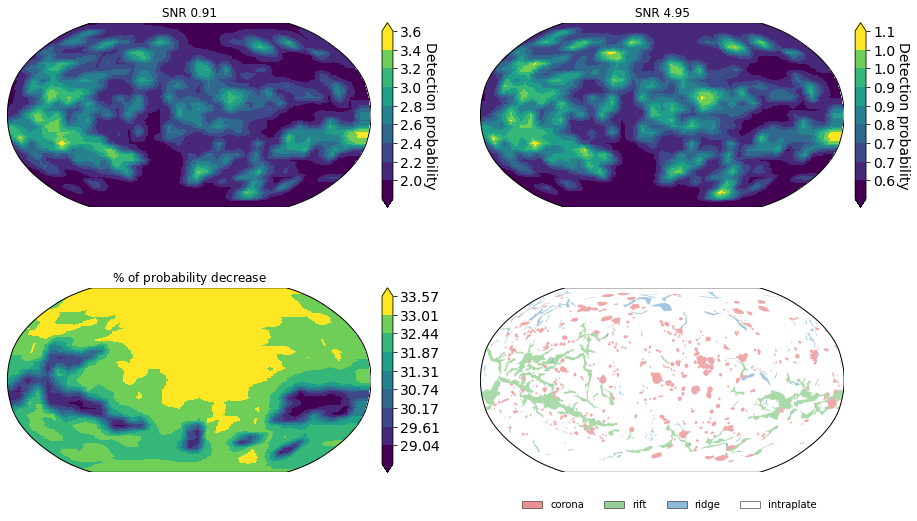

In [290]:
reload(pm)
opt_visualization = dict(
    VENUS = pm.get_regions('../../../Venus_data/'),
    c_cbar = 'black', 
    l_snr_to_plot = [1.,5.], 
    n_colors = 10,
    #low_cmap = np.arange(0.25, 2, 0.25),
    #high_cmap = np.arange(3.5, 7, 0.5), # 1 day RW low activity
    plot_all_regions = True,
    plot_volcanoes = False
)

pm.plot_map(proba_model, **opt_visualization)

In [309]:
reload(pm)

file = './test_data_Venus/trajectory_balloon_lat0.00_lon0.00_15days.csv'
file = './test_data_Venus/trajectory_balloon_lat50.00_lon50.00_15days.csv'
trajectory = pd.read_csv(file, header=[0])
new_trajectories = pm.compute_proba_one_trajectory(trajectory, proba_model_volcanoes, norm_factor_time=3600.)
#new_trajectories.to_csv(file.replace('.csv', '_high.csv'), header=True, index=False)

100%|██████████| 262/262 [00:02<00:00, 110.24it/s]


/staff/quentin/Documents/Projects/2023_Celine_internship/msc_celine_specfem/utils/utils_NORSAR/proba_modules.py:1019: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, toplot, zorder=0, cmap='Reds')


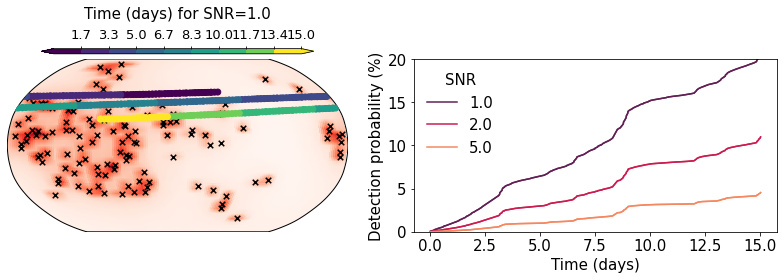

In [310]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=1., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 20.],
    plot_time=True,
    plot_volcanoes=True
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model_volcanoes, **opt_visualization)

/staff/quentin/Documents/Projects/2023_Celine_internship/msc_celine_specfem/utils/utils_NORSAR/proba_modules.py:1019: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, toplot, zorder=0, cmap='Reds')


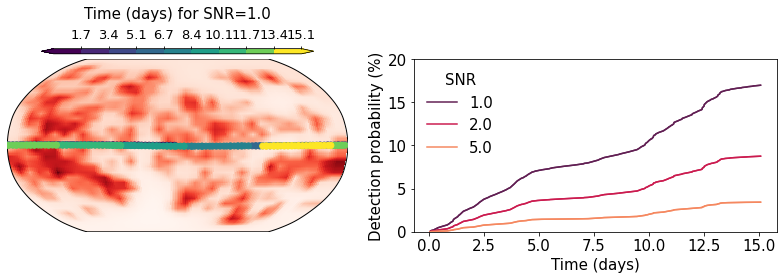

In [307]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=1., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 20.],
    plot_time=True,
    plot_volcanoes=False
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model, **opt_visualization)

## Older version

In [1]:
import obspy
import pandas as pd
from pyproj import Geod
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime
import os
from sklearn.neighbors import KernelDensity
from pyrocko import moment_tensor as mtm
from tqdm import tqdm
import geopandas as gpd 
from importlib import reload

## Load tectonic regions of Venus

In [ ]:
PATH_VENUS_DATA = os.path.join("../../../Venus_data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}tectonic_settings_Venus")
VENUS = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp")
}

## Load distribution quakes per region

In [ ]:
def return_number_per_cat_and_setting(mw, pd_slopes, cat_quake, setting):
    
    slope = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='slope'), cat_quake].iloc[0]
    intercept = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='intercept'), cat_quake].iloc[0]
    func = lambda mw: 10**(np.log10(mtm.magnitude_to_moment(mw))*slope+intercept)
    return func(mw)

pd_slopes = pd.read_csv(f'{PATH_VENUS_DATA}distribution_venus_per_mw.csv', header=[0])
# e.g., return_number_per_cat_and_setting(5., pd_slopes, 'rifts', 'active_high_max')

In [ ]:
pd_slopes

## Load TL curves for each moment tensor, depth, azimuth, and crustal thickness

In [ ]:
from scipy import interpolate
from pyrocko import moment_tensor as pmt
from obspy.geodetics import kilometers2degrees, degrees2kilometers

TL = {}
type_fit = 'a*(dists.min()/dist)**b + c*(dists.min()/dist)**d'
type_mecha = 'M1'
altitude = 60.
depth = 10.
crustal_thickness = 11

mw_output = 5.
format_TL = f'./test_data_Venus/TL_{type_mecha}_d{depth:.0f}_c{crustal_thickness:.0f}_a{altitude:.0f}_mw{mw_output:.0f}.csv'
#format_TL = f'./test_data_Venus/TL_{type_mecha}_d{depth:.0f}_c{crustal_thickness:.0f}_a{altitude:.0f}_mw{mw_output:.0f}.csv'
coefs = pd.read_csv(format_TL, header=[0],).values[0,:]
type_fit, dist_min, m0_orig, norm_factor, a, b, c, d = coefs
TL_base = lambda dist, m0: (a*(dist_min/dist)**b + c*(dist_min/dist)**d)*mtm.magnitude_to_moment(m0)*norm_factor/m0_orig
TL[mw_output] = lambda dist, m0: TL_base(dist, m0)*(dist>=dist_min) + TL_base(dist_min, m0)*(dist<dist_min)

period = 5.
dist_min = 100.
## Mag vs amp relationship -> https://gfzpublic.gfz-potsdam.de/rest/items/item_65142/component/file_292577/content
TL_base_seismic_disp = lambda dist, m0: 10**(m0 -1.66*np.log10(kilometers2degrees(dist)) -3.3)*period # eq. 3
TL_base_seismic = lambda dist, m0: 1e-6*TL_base_seismic_disp(dist, m0)*2*np.pi/period
#TL_base_seismic = lambda dist, m0: 10**(m0 -1.66*np.log10(kilometers2degrees(dist)) -3.3)*2*np.pi # eq. 4

pd_all_amps = pd.read_csv('./test_data_Venus/GF_reverse_fault_1Hz_c15km.csv', header=[0])
f_mean = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps.median_rw.values, bounds_error=False, fill_value=(pd_all_amps.median_rw.iloc[0], pd_all_amps.median_rw.iloc[-1]))
#f_std = interpolate.interp1d(pd_all_amps.dist.values, pd_all_amps['std'].values, bounds_error=False, fill_value=(pd_all_amps['std'].max(), pd_all_amps['std'].min()))
f_qmin = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.25_rw'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.25_rw'].iloc[0], pd_all_amps['median_q0.25_rw'].iloc[-1]))
f_qmax = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.75_rw'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.75_rw'].iloc[0], pd_all_amps['median_q0.75_rw'].iloc[-1]))

"""
f_mean = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps.median_body.values, bounds_error=False, fill_value=(pd_all_amps.median_body.iloc[0], pd_all_amps.median_body.iloc[-1]))
f_qmin = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.25_body'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.25_body'].iloc[0], pd_all_amps['median_q0.25_body'].iloc[-1]))
f_qmax = interpolate.interp1d(degrees2kilometers(pd_all_amps.dist.values), pd_all_amps['median_q0.75_body'].values, bounds_error=False, fill_value=(pd_all_amps['median_q0.75_body'].iloc[0], pd_all_amps['median_q0.75_body'].iloc[-1]))
"""

TL_base_seismic = lambda dist, m0: pmt.magnitude_to_moment(m0)*f_mean(dist)
#TL_base_seismic_std = lambda dist, m0: pmt.magnitude_to_moment(m0)*f_std(dist)
TL_base_seismic_qmin = lambda dist, m0: pmt.magnitude_to_moment(m0)*f_qmin(dist)
TL_base_seismic_qmax = lambda dist, m0: pmt.magnitude_to_moment(m0)*f_qmax(dist)

rho0, c0, rhob, cb = 50, 400, 1, 250
density_ratio = rhob*cb*np.sqrt(rho0*c0/(rhob*cb))
#TL_base = lambda dist, m0: density_ratio*(TL_base_seismic(dist,m0)*1e-6)/(2*np.pi*period) # Raphael
TL_base = lambda dist, m0: density_ratio*(TL_base_seismic(dist,m0))
TL_base_qmin = lambda dist, m0: density_ratio*(TL_base_seismic_qmin(dist,m0))
TL_base_qmax = lambda dist, m0: density_ratio*(TL_base_seismic_qmax(dist,m0))
#TL_base = lambda dist, m0: Ti*(TL_base_seismic(dist,m0))
#TL[mw_output] = lambda dist, m0: TL_base(dist, m0)*(dist>=dist_min) + TL_base(dist_min, m0)*(dist<dist_min)
TL_new = lambda dist, m0: TL_base(dist, m0)*(dist>=dist_min) + TL_base(dist_min, m0)*(dist<dist_min)
TL_new_qmin = lambda dist, m0: TL_base_qmin(dist, m0)*(dist>=dist_min) + TL_base_qmin(dist_min, m0)*(dist<dist_min)
TL_new_qmax = lambda dist, m0: TL_base_qmax(dist, m0)*(dist>=dist_min) + TL_base_qmax(dist_min, m0)*(dist<dist_min)

dists = np.linspace(10., 18e3, 100)
mags = [5., 6.]
noise_level = 5e-2
plt.figure()
for imag, mag in enumerate(mags):
    label = dict()
    if imag == len(mags)-1:
        label['label'] = 'uncertainty'
    plt.plot(dists, TL_new(dists, mag)/noise_level, label=mag, linewidth=3.)
    plt.fill_between(dists, TL_new_qmin(dists, mag)/noise_level, TL_new_qmax(dists, mag)/noise_level, color='grey', alpha=0.3, **label)

plt.yscale('log')
plt.xlabel('Distance (km)', fontsize=12.)
plt.ylabel('Amplitude (Pa)', fontsize=12.)
plt.legend(frameon=False, fontsize=12.)
plt.savefig('./test_data_Venus/TL_examples.png', transparent=True)
    
"""
eps = 0.3
dists = np.linspace(1., 19000.)
plt.figure()
plt.plot(dists, TL[5.](dists, 4.))
plt.fill_between(dists, TL[5.](dists, 4.-eps), TL[5.](dists, 4.+eps), color='grey', alpha=0.5)
plt.plot(dists, TL[5.](dists, 5.))
plt.fill_between(dists, TL[5.](dists, 5.-eps), TL[5.](dists, 5.+eps), color='grey', alpha=0.5)
plt.plot(dists, TL[5.](dists, 6.))
plt.plot(dists, TL_base_seismic(dists, 4.), linestyle=':')
plt.plot(dists, TL_base_seismic(dists, 5.), linestyle=':')
plt.plot(dists, TL_base_seismic(dists, 6.), linestyle=':')
plt.xlabel('Distance (km)')
plt.ylabel('Pressure (Pa)')
plt.yscale('log')

noise_level = 1e-2
plt.figure()
plt.plot(dists, TL[5.](dists, 4.)/noise_level)
#plt.fill_between(dists, TL[5.](dists, 4.-eps)/noise_level, TL[5.](dists, 4.+eps)/noise_level, color='grey', alpha=0.5)
plt.fill_between(dists, TL[5.](dists, 4.)*(2-10**(eps)/noise_level), TL[5.](dists, 4.)*10**(eps)/noise_level, color='grey', alpha=0.5)
plt.yscale('log')

plt.figure()
SNR = np.linspace(0., 50., 100)
plt.plot(SNR, np.exp(-(1./(0.5*SNR))**2))
plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('Detection probability')
plt.ylim([0., 1.])
"""

## Load surface ratios

In [ ]:
surface_ratios = pd.read_csv('./test_data_Venus/surface_ratios_fixed.csv')
surface_ratios.loc[surface_ratios.radius==surface_ratios.radius.min(), 'ratio_map'] = 0.
surface_ratios.loc[surface_ratios.radius==surface_ratios.radius.min(), 'ratio'] = 0.

In [ ]:
#plt.figure()
#plt.plot(dists, RATIOs[region].reshape(shape_init)[0,:,0,0])
#plt.plot(dists, RATIOs[region].reshape(shape_init)[0,:,0,20])
lats, lons = np.arange(-20, 25, 10), np.arange(-20, 25, 10)
lats, lons = [0.], [0.]
lats, lons = np.meshgrid(lats, lons)
lats, lons = lats.ravel(), lons.ravel()

for lat, lon in zip(lats, lons):

    l_radius = surface_ratios.radius.unique()
    l_iloc = surface_ratios['iloc'].unique()
    l_lats = [surface_ratios.loc[surface_ratios['iloc']==iloc, 'lat'].iloc[0] for iloc in l_iloc]
    l_lons = [surface_ratios.loc[surface_ratios['iloc']==iloc, 'lon'].iloc[0] for iloc in l_iloc]

    plt.figure()
    #plt.title(f'{surface_ratios_region_iloc["iloc"].iloc[0]} - lon/lat: {surface_ratios_region_iloc.lon.iloc[0]}/{surface_ratios_region_iloc.lat.iloc[0]}')
    for region, surface_ratios_region in surface_ratios.groupby('region'):
        #surface_ratios_region = surface_ratios.loc[surface_ratios.region=='rift']

        #ratios = surface_ratios_region['ratio'].values.reshape((l_iloc.size, l_radius.size)) # iloc x radius
        isurface = np.argmin(np.sqrt((lat-np.array(l_lats))**2+(lon-np.array(l_lons))**2))
        isurface = 306
        surface_ratios_region_iloc = surface_ratios_region.loc[surface_ratios_region['iloc']==isurface]
        plt.plot(surface_ratios_region_iloc.radius, surface_ratios_region_iloc.ratio_map)


## Probabilistic model

In [ ]:
from tqdm import tqdm
from scipy import special

#TL = lambda distance, M0: (M0**2)/distance**0.7
def compute_TL(DISTS_r, MAG_r):
    
    l_M0s = [key for key in TL]
    if isinstance(DISTS_r, float) or isinstance(MAG_r, float):
        
        mag = MAG_r
        if mag in l_M0s:
            TL_loc = TL[mag]
        else:
            TL_loc = TL[l_M0s[np.argmin(abs(np.array(l_M0s)-mag))]]
                
        TL_r = TL_loc(DISTS_r, MAG_r)
        
    else:
    
        TL_r = np.zeros_like(MAG_r)
        for imag, mag in enumerate(MAG_r[:,0,0]):

            if mag in l_M0s:
                TL_loc = TL[mag]
            else:
                TL_loc = TL[l_M0s[np.argmin(abs(np.array(l_M0s)-mag))]]

            TL_r[imag,:] = TL_loc(DISTS_r[imag,:], mag)
            
    return TL_r

#Nquake_over_mag = lambda M0, iregion: -7.*M0 +7*8 
#Nquake_mag = lambda m_min, m, iregion: (Nquake_over_mag(m_min, iregion)-Nquake_over_mag(m, iregion))/Nquake_over_mag(m_min, iregion)
#Nquake_over_mag = lambda m, iregion: return_number_per_cat_and_setting(m, pd_slopes, 'rifts', 'active_high_max')
#Nquake_mag = lambda m_min, m, iregion: (Nquake_over_mag(m_min, iregion)-Nquake_over_mag(m, iregion))/Nquake_over_mag(m_min, iregion)
#def compute_ratemag(MAG, M0s, iregion):
    #f_mag = Nquake_mag(M0s.min(), M0s, iregion)
def compute_ratemag(shape_init, pd_slopes, M0s, region, scenario, m_min, dproba_M0s, homogeneous_ratios=False):
    
    Nquake_over_mag = return_number_per_cat_and_setting(M0s, pd_slopes, region, scenario)
    Nquake_over_mag_min = return_number_per_cat_and_setting(m_min, pd_slopes, region, scenario)
    Nquake_mag = (Nquake_over_mag_min-Nquake_over_mag)/Nquake_over_mag_min
    f_mag = np.gradient(Nquake_mag, dproba_M0s, edge_order=2)
    F_MAGS = np.zeros(shape_init)
    F_MAGS += f_mag[:,np.newaxis,np.newaxis,np.newaxis]
    return F_MAGS

def generate_random_data():
    
    mu = np.random.uniform(0, 0.5)
    sigma = np.random.uniform(0, 0.2)
    amp = np.random.rand()*(1-mu)
    cutoffs_min = np.random.uniform(0, 0.5)
    cutoffs_max = np.random.uniform(cutoffs_min+0.1, 1.)
    ratio_loc = amp*0.5*(1+special.erf( (np.linspace(0., 1, dists.size)-mu)/(sigma*np.sqrt(2.)) ))
    ratio_loc -= ratio_loc.min()
    ratio_loc_new = ratio_loc + np.cumsum(np.random.uniform(0,ratio_loc.max()/20.,ratio_loc.size))
    ratio_loc = ratio_loc_new
    ratio_loc_shifted = np.zeros_like(ratio_loc)
    ratio_loc_shifted[int(cutoffs_min*dists.size):] = ratio_loc[:ratio_loc.size-int(cutoffs_min*dists.size)]
    ratio_loc_shifted[int(cutoffs_max*dists.size):] = ratio_loc_shifted[int(cutoffs_max*dists.size)]
    d_distance = dists[1]-dists[0]

    inds_over_zero = np.arange(int(cutoffs_min*dists.size), int(cutoffs_max*dists.size))
    gd_ratio_loc_shifted = np.zeros_like(ratio_loc_shifted)
    gd_ratio_loc_shifted[inds_over_zero] = np.gradient(ratio_loc_shifted[inds_over_zero], d_distance)
    return gd_ratio_loc_shifted

"""
def compute_ratio_vs_loc(DISTS, LOC, regions):
    
    g = Geod(ellps='WGS84')
    
    RATIOs = []
    for iregion, region in enumerate(regions):
        
        RATIO = np.zeros_like(DISTS)
        #lat0, lon0, r0 = 20., 10., 2000.
        lat0, lon0, r0 = region
        for iloc, loc in tqdm(enumerate(locations), total=locations.size):

            lon, lat = lons[iloc], lats[iloc]
            _, _, dist_center = g.inv(lon0, lat0, lon, lat)

            dist_min, dist_max = max(0., dist_center/1e3-r0), min(dist_center/1e3+r0, 2*np.pi*r_venus)
            #dist_min, dist_max = max(0., dist_center/1e3-2*np.pi*r0), min(dist_center/1e3+2*np.pi*r0, 2*np.pi*r_venus)
            gd_ratio_loc_shifted = np.zeros_like(dists)
            ind_start, ind_end = np.argmin(abs(dists-dist_min)), np.argmin(abs(dists-dist_max))
            gd_ratio_loc_shifted[ind_start:ind_end] = np.linspace(0., dists[ind_end]/dist_max, ind_end-ind_start)
            #gd_ratio_loc_shifted[ind_end:] = gd_ratio_loc_shifted[ind_end-1]
            if ind_end-ind_start > 5:
                gd_ratio_loc_shifted[ind_start:ind_end] = np.gradient(gd_ratio_loc_shifted[ind_start:ind_end], dproba_dists)
            RATIO[:,:,:,iloc] += gd_ratio_loc_shifted[np.newaxis, :, np.newaxis]
        
        RATIOs.append( RATIO )
        
    return RATIOs
"""
def compute_ratio_vs_loc(shape_init, lats, lons, dists, locations, surface_ratios, region, r_venus, dproba_dists, homogeneous_ratios=False):
    
    surface_ratios_region = surface_ratios.loc[surface_ratios.region==region]
    l_radius = surface_ratios_region.radius.unique()
    l_iloc = surface_ratios_region['iloc'].unique()
    l_lats = [surface_ratios_region.loc[surface_ratios_region['iloc']==iloc, 'lat'].iloc[0] for iloc in l_iloc]
    l_lons = [surface_ratios_region.loc[surface_ratios_region['iloc']==iloc, 'lon'].iloc[0] for iloc in l_iloc]
    ratios = surface_ratios_region['ratio'].values.reshape((l_iloc.size, l_radius.size)) # iloc x radius
    RATIOs = np.zeros(shape_init)
    
    for iloc in locations:
        
        if homogeneous_ratios:
            dist_degree = np.radians((dists/(np.pi*r_venus))*180.)
            ratios_values_interp = (1-np.cos(dist_degree))/2.
        else:
            isurface = np.argmin(np.sqrt((lats[iloc]-l_lats)**2+(lons[iloc]-l_lons)**2))
            surface_ratios_region_iloc = surface_ratios_region.loc[surface_ratios_region['iloc']==isurface]
            radius_values = surface_ratios_region_iloc.radius.values
            ratios_values = surface_ratios_region_iloc.ratio.values
            ratios_values_interp = np.interp(dists, radius_values/1e3, ratios_values)
        
        RATIOs[:,:,:,iloc] = np.gradient(ratios_values_interp, dproba_dists)[np.newaxis,:,np.newaxis]
        #RATIOs[:,:,:,iloc] = ratios_values_interp[np.newaxis,:,np.newaxis]
        
        """
        if iloc == 9:
            plt.figure()
            plt.title(f'{region}: {isurface}')
            plt.plot(dists, ratios_values_interp)
            plt.plot(radius_values/1e3, ratios_values)
        """
            
    return RATIOs
        
def compute_detection_proba_per_SNR(SNR): 
    #return np.exp(-(1./(0.5*SNR))**2)
    proba = np.zeros_like(SNR)
    proba[np.where((SNR >= 1)&(SNR < 2))[0]] = 0.5
    proba[np.where(SNR >= 2)[0]] = 1.
    return proba

#def compute_pdf(DISTS, MAG, DETECT_T):
#    return (1./(compute_detection_proba_per_SNR(sigma_TL/noise_level)*np.sqrt(2*np.pi)))*np.exp(-0.5*((DETECT_T-compute_detection_proba_per_SNR(TL(DISTS, MAG)/noise_level))/compute_detection_proba_per_SNR(sigma_TL/noise_level))**2)

def compute_cum_pdf(DISTS, MAG, DETECT_T, shape_init):
    
    """
    #detection_thresholds_loc = detection_thresholds # Could be changed to any list of detection thresholds
    if False:
        total_pdf = np.zeros(shape_init)
        #DISTS_r, MAG_r, DETECT_T_r =  DISTS.reshape(shape_init), MAG.reshape(shape_init), DETECT_T.reshape(shape_init)
        for iproba, proba_threshold in tqdm(enumerate(detection_thresholds_loc), total=detection_thresholds_loc.size):

            #inds = np.where(detection_thresholds>=proba_threshold)[0]
            #pdf = compute_pdf(DISTS_r[:,:,inds,:], MAG_r[:,:,inds,:], DETECT_T_r[:,:,inds,:])
            #total_pdf[:,:,iproba,:] = dproba_threshold*pdf.sum(axis=2)
            
            #summed_pdf = np.zeros_like(DISTS)
            #inds = DETECT_T>=proba_threshold
            #pdf = compute_pdf(DISTS[inds], MAG[inds], DETECT_T[inds])
            #summed_pdf[inds] = pdf
            #total_pdf[:,:,iproba,:] = summed_pdf.reshape(shape_init).sum(axis=2)
            
    """
    DISTS_r, MAG_r, DETECT_T_r =  DISTS.reshape(shape_init), MAG.reshape(shape_init), DETECT_T.reshape(shape_init)
    #sigma = compute_detection_proba_per_SNR(np.array([sigma_TL/noise_level]))[0]
    #mu = compute_detection_proba_per_SNR(TL(DISTS_r[:,:,:,0], MAG_r[:,:,:,0])/noise_level)
    
    #mu = TL(DISTS_r[:,:,:,0], MAG_r[:,:,:,0])/noise_level
    #mu = compute_TL(DISTS_r[:,:,:,0], MAG_r[:,:,:,0])/noise_level
    #sigma = np.array([sigma_TL/noise_level])[0] # Old equation with constant sigma, sigma depends on magnitude
    #sigma = 0.5*mu*(10**sigma_TL - 10**(-sigma_TL))
    #sigma = mu*(10**sigma_TL - 1.)
    x = DISTS_r[:,:,:,0]
    mu = TL_new(x, MAG_r[:,:,:,0])/noise_level
    sigma_qmax = TL_base_seismic_qmax(x, MAG_r[:,:,:,0])/noise_level
    sigma_qmin = TL_base_seismic_qmin(x, MAG_r[:,:,:,0])/noise_level
    
    total_pdf = np.zeros(shape_init)
    cums_max = 1-0.5*(1+special.erf( (DETECT_T_r[:,:,:,0]-mu)/(sigma_qmax*np.sqrt(2.)) ))
    cums_min = 1-0.5*(1+special.erf( (DETECT_T_r[:,:,:,0]-mu)/(sigma_qmin*np.sqrt(2.)) ))
    
    cums = np.where(DETECT_T_r[:,:,:,0] < mu, cums_min, cums_max)
    
    total_pdf += cums[:,:,:,np.newaxis]
        
    return total_pdf.ravel()
    
def integrate_cum_pdf(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, shape_init):
    total_pdf = compute_cum_pdf(DISTS, MAG, DETECT_T, shape_init)
    
    integrated = {}#np.zeros((shape_init[2], shape_init[3]))
    for region in RATIOs:
        integrated[region] = (F_MAGS[region]*RATIOs[region]*total_pdf).reshape(shape_init).sum(axis=(0,1)) 
        
    return integrated

def compute_rate(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, pd_slopes, scenario, shape_init, surface_ratios, dproba_M0s, dproba_dists, homogeneous_ratios=False):
    Nquake_over_mag = lambda region: return_number_per_cat_and_setting(m_min, pd_slopes, region, scenario)
    if homogeneous_ratios:
        region_str = {}
        region_str['coronae'] = 'corona'
        region_str['ridges'] = 'ridge'
        region_str['rifts'] = 'rift'
        region_str['intraplate'] = 'intraplate'
        l_regions = pd_slopes.loc[:,~pd_slopes.columns.isin(['type_setting', 'type_unknown'])].columns.values
        Nquake_over_mag = lambda region: np.sum([surface_ratios.loc[surface_ratios['region']==region_str[one_region]].ratio.max()*return_number_per_cat_and_setting(m_min, pd_slopes, one_region, scenario) for one_region in l_regions])
        #print(Nquake_over_mag('intraplate'))
        
    integrals = integrate_cum_pdf(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, shape_init)
    return [Nquake_over_mag(region)*dproba_dists*dproba_M0s*integrals[region] for region in integrals]

def compute_Poisson(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, duration, pd_slopes, scenario, shape_init, surface_ratios, dproba_M0s, dproba_dists, return_rate=False, rates=None, homogeneous_ratios=False):
    if rates is None:
        rates = compute_rate(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, pd_slopes, scenario, shape_init, surface_ratios, dproba_M0s, dproba_dists, homogeneous_ratios=homogeneous_ratios)
    proba = 1.-np.prod([np.exp(-duration*rate) for rate in rates], axis=0)
    if return_rate:
        return proba, rates
    return proba

def compute_proba_map(scenario, dists, M0s, SNR_thresholds, noise_level, duration, all_lats, all_lons, pd_slopes, surface_ratios, homogeneous_ratios=False, m_min=3., r_venus=6052, verbose=False):
    
    #dproba_threshold = detection_thresholds[1]-detection_thresholds[0]
    dSNR_threshold = SNR_thresholds[1]-SNR_thresholds[0]
    dproba_dists = dists[1]-dists[0]
    dproba_M0s = M0s[1]-M0s[0]

    DISTS, MAG, DETECT_T, LOC, RATIOs, F_MAGS = None, None, None, None, None, None
    
    proba_all_other = np.zeros((SNR_thresholds.size, all_lats.size, all_lons.size))
    for ilon, lon in tqdm(enumerate(all_lons), total=len(all_lons)):

        lats_orig, lons_orig = all_lats, np.array([lon])
        lats, lons = np.meshgrid(lats_orig, lons_orig)
        lats, lons = lats.ravel(), lons.ravel()
        locations = np.arange(lats.size)

        #DISTS, MAG, DETECT_T, LOC = np.meshgrid(dists, M0s, detection_thresholds, locations)
        DISTS, MAG, DETECT_T, LOC = np.meshgrid(dists, M0s, SNR_thresholds, locations) # M0s x dists x SNR x loc
        shape_init = DISTS.shape
        #print(shape_init)

        #F_MAGS = []
        #for iregion in range(len(regions)):
            #F_MAGS.append( compute_ratemag(MAG, M0s, iregion).ravel() )
        F_MAGS = {}
        RATIOs = {}
        l_regions = pd_slopes.loc[:, ~pd_slopes.columns.str.contains('type')].columns.values
        for region in l_regions:
            
            if (not region=='intraplate') and 'inactive' in scenario:
                if verbose:
                    print(f'Inactive scenario - Skipping region {region}')
                continue
            
            if verbose:
                print(f'Computing rate for region: {region}')
            F_MAGS[region] = compute_ratemag(shape_init, pd_slopes, M0s, region, scenario, m_min, dproba_M0s=dproba_M0s, homogeneous_ratios=homogeneous_ratios).ravel() 
            #RATIOs[region] = compute_ratio_vs_loc(DISTS, LOC, regions)
            region_str = region
            if region_str == 'coronae':
                region_str = 'corona'
            elif region_str == 'ridges':
                region_str = 'ridge'
            elif region_str == 'rifts':
                region_str = 'rift'
            if (not homogeneous_ratios) or (homogeneous_ratios and region=='intraplate'): # only need one region if homogeneous distributions of venusquakes
                if verbose:
                    print(f'Computing surface ratio for region: {region}')
                RATIOs[region] = compute_ratio_vs_loc(shape_init, lats, lons, dists, locations, surface_ratios, region_str, r_venus, dproba_dists, homogeneous_ratios=homogeneous_ratios).ravel()

        if homogeneous_ratios:
            region_str = {}
            region_str['coronae'] = 'corona'
            region_str['ridges'] = 'ridge'
            region_str['rifts'] = 'rift'
            region_str['intraplate'] = 'intraplate'
            F_MAGS['intraplate'] *= surface_ratios.loc[surface_ratios.region=='intraplate'].ratio.max()
            for region in l_regions:
                if not region=='intraplate':
                    F_MAGS['intraplate'] += F_MAGS[region]*surface_ratios.loc[surface_ratios.region==region_str[region]].ratio.max()
                    if verbose:
                        print(f'Combining rate of region {region} into intraplate')
                    del F_MAGS[region]

        #RATIOs = [ratio.ravel() for ratio in compute_ratio_vs_loc(DISTS, LOC, regions)]
        DISTS, MAG, DETECT_T, LOC = DISTS.ravel(), MAG.ravel(), DETECT_T.ravel(), LOC.ravel()

        m_min = M0s.min()
        #cum_pdf = compute_cum_pdf(DISTS, MAG, DETECT_T).reshape(shape_init)
        proba, rates = compute_Poisson(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, duration, pd_slopes, scenario, shape_init, surface_ratios, dproba_M0s, dproba_dists, return_rate=True, homogeneous_ratios=homogeneous_ratios)
        proba_all_other[:,:,ilon] = proba
    return proba_all_other

r_venus = 6052
#scenario = 'active_high_min' # Iris' seismicity scenario
scenario = 'inactive_min' # Iris' seismicity scenario
dists = np.arange(10., np.pi*r_venus, 200) # Low discretization will lead to terrible not unit integrals
M0s = np.linspace(3., 8., 30) # Low discretization will lead to terrible not unit integrals
SNR_thresholds = np.linspace(0.1, 10., 50)
noise_level = 5e-2 # noise level in Pa
duration = 1./(365.*24) # (1/mission_duration)

homogeneous_ratios = False
dlat = 5.
all_lats = np.arange(-90., 90.+dlat, dlat)
all_lons = np.arange(-180, 180+dlat*2, dlat*2)
proba_all_other_high = compute_proba_map(scenario, dists, M0s, SNR_thresholds, noise_level, duration, all_lats, all_lons, pd_slopes, surface_ratios, homogeneous_ratios=False, m_min=3., r_venus=6052)

homogeneous_ratios = True
dlat = 50.
all_lats_homo = np.arange(-89., 90., dlat)
all_lons_homo = np.arange(-180, 179, dlat*2)
#proba_all_homo = compute_proba_map(scenario, dists, M0s, SNR_thresholds, noise_level, duration, all_lats_homo, all_lons_homo, pd_slopes, surface_ratios, homogeneous_ratios=homogeneous_ratios, m_min=3., r_venus=6052)

## Visualize internal PDFs (i.e., step by step process) 

In [ ]:
mag, dist = 5., 1000.

imag = np.argmin(abs(M0s-mag))
iloc = 9
isnr = 5

durations = np.linspace(1./365., 100./365., 50)
DUR, THRESH = np.meshgrid(durations, SNR_thresholds)
proba_durations = np.zeros((durations.size,)+proba.shape)
for iduration, duration in enumerate(durations):
    proba_durations[iduration,:,:] = compute_Poisson(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, duration, pd_slopes, scenario, rates=rates)

fig = plt.figure(figsize=(16,3))
grid = fig.add_gridspec(1, 6)

ax = fig.add_subplot(grid[0, 0])
for dist in [500., 1000.]:
    idist = np.argmin(abs(dists-dist))
    #sigma = sigma_TL/noise_level
    #mu = TL(dists[idist], M0s[imag])/noise_level
    mu = compute_TL(dists[idist], M0s[imag])/noise_level
    sigma = mu*(10**sigma_TL - 1.)
    ax.plot(SNR_thresholds, (1./(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((SNR_thresholds-mu)/sigma)**2))
ax.set_title(M0s[imag])

ax = fig.add_subplot(grid[0, 1])
#ax.plot(detection_thresholds, cum_pdf[imag, idist, :, iloc])
test_cum = 0.5*(1+special.erf( (SNR_thresholds-mu)/(sigma*np.sqrt(2.)) ))
ax.plot(SNR_thresholds, 1-test_cum)
ax.set_ylim([0.,1])

ax = fig.add_subplot(grid[0, 2])
for rate in rates:
    ax.plot(SNR_thresholds, rate[:,iloc])
ax.set_yscale('log')

ax = fig.add_subplot(grid[0, 3])
ax.pcolormesh(THRESH, DUR*12, proba_durations[:,:,iloc].T, vmax=1., vmin=0.)
ax.set_title(f'lat/lon: {lats[iloc]:.2f}/{lons[iloc]:.2f}')
#ax.plot(proba_durations[20,:,iloc])
#ax.set_ylim([-0.,1.1])

ax = fig.add_subplot(grid[0, 4])
for region in RATIOs:
    ax.plot(dists, RATIOs[region].reshape(shape_init)[0,:,0,iloc])
    
ax = fig.add_subplot(grid[0, 5])
sc = ax.pcolormesh(all_lons, all_lats, proba_all_other[isnr,:])
#sc = ax.plot(lats_orig, proba_all_other[isnr,:,ilon])
ax.set_title(f'SNR: {SNR_thresholds[isnr]:.2f}')
plt.colorbar(sc)
#ax.set_ylim([0.,1.1])

## Visualize global probability maps

In [236]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import NearestNDInterpolator
from matplotlib.ticker import FuncFormatter, LogFormatterExponent
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcol

from matplotlib.patches import Polygon
from sklearn.cluster import DBSCAN

def draw_screen_poly(xy, ax, legend, color='red'):
    #x, y = m( lons, lats )
    #xy = zip(x,y)
    poly = Polygon( xy, facecolor=color, alpha=0.4, **legend )
    ax.add_patch(poly)

def plot_regions(m, ax, VENUS):

    color_dict = {'corona': 'tab:red', 'rift': 'tab:green', 'ridge': 'tab:blue', 'intraplate': 'white'}
    for region in VENUS:
        if region == 'intraplate':
            continue
        print(f'Processing region {region}')
        added_legend = False
        for ext in tqdm(VENUS[region].exterior):
            if ext is None:
                continue
            surface2 = [m(lon,lat) for lon, lat in list(ext.coords)]
            
            clustering = DBSCAN(eps=500000, min_samples=5).fit(np.array(surface2))
            lines = []
            for label in np.unique(clustering.labels_):
                coords = np.array(surface2)[clustering.labels_==label]
                legend = {}
                #if not added_legend:
                #    added_legend = True
                #    legend['label'] = region
                draw_screen_poly(coords, ax, legend, color=color_dict[region])
                
    import matplotlib.patches as mpatches
    
    patches = [mpatches.Patch(facecolor=color_dict[region], label=region, alpha=0.5, edgecolor='black') for region in color_dict]
    ax.legend(handles=patches, frameon=False, bbox_to_anchor=(0.95, -0.1), ncol=4, bbox_transform=ax.transAxes)
    
def one_map(ax, fig, proba, lats, lons, SNR_thresholds, snr, n_colors, show_title,  c_cbar = 'white', l_snr_to_plot=[], low_cmap=[], high_cmap=np.arange(1.2e-1, 1.5e-1, 0.05e-1), interpolate=True, proba_all_homo=None):
    
    m = Basemap(projection='robin', lon_0=0, ax=ax)
            
    LAT, LON = np.meshgrid(lats, lons)
    shape = LON.shape
    x, y = m(LON.ravel(), LAT.ravel())
    x, y = x.reshape(shape), y.reshape(shape)

    isnr = np.argmin(abs(SNR_thresholds-snr))
    toplot = proba[isnr,:].reshape(shape)*1e2
    if proba_all_homo is not None:
        toplot /= proba_all_homo[isnr,0,0]*1e2
        toplot = 1e2*(1.-toplot)
    
    fmt = lambda x, pos: '{:.1f}'.format(x) # 
    if l_snr_to_plot:
        isnr = np.argmin(abs(SNR_thresholds-l_snr_to_plot[0]))
        toplot = proba[isnr,:].reshape(shape)*1e2
        isnr = np.argmin(abs(SNR_thresholds-l_snr_to_plot[1]))
        toplot = 1e2*(1-(toplot - proba[isnr,:].reshape(shape)*1e2)/toplot)
        #toplot = 1e2*(1-proba[isnr,:].reshape(shape)/toplot)
        fmt = lambda x, pos: '{:.2f}'.format(x) # 
        
    if show_title:
    #    #ax.set_title(f'Detection probability over {duration:.2f} days')
        if l_snr_to_plot:
            ax.set_title(f'$\%$ of probability decrease')
        else:
            ax.set_title(f'SNR {SNR_thresholds[isnr]:.2f}')
            
    #print(low_cmap)
    if l_snr_to_plot or len(low_cmap)==0:
        cmap_bounds = np.linspace(toplot.min(), toplot.max(), n_colors)
    else:
        cmap_bounds = [0] + [c for c in low_cmap] + [c for c in high_cmap] # ISSI
    
    cmap = cm.get_cmap("viridis", lut=len(cmap_bounds))
    norm = mcol.BoundaryNorm(cmap_bounds, cmap.N)
    
    if interpolate:
        dnew = 1.
        lons_new = np.arange(lons.min(), lons.max(), 2*dnew)
        lats_new = np.arange(lats.min(), lats.max(), dnew)
        
        LAT, LON = np.meshgrid(lats_new, lons_new)
        shape = LON.shape
        x, y = m(LON.ravel(), LAT.ravel())
        x, y = x.reshape(shape), y.reshape(shape)
        
        interpolator = RectBivariateSpline(lons, lats, toplot, kx=1, ky=1)
        toplot = interpolator.ev(LON.ravel(), LAT.ravel()).reshape(shape)
        
    sc = m.pcolormesh(x, y, toplot, alpha=1, cmap=cmap, norm=norm)
    #sc = m.pcolormesh(x.T, y.T, proba[isnr,:]*100, alpha=1,)# cmap=cmap, norm=norm)
    #print(x, y)

    axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.03, 0., 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = fig.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='vertical', extend='both', ticks=cmap_bounds[1:],)
   
    fontsize = 14.
    cbar.ax.tick_params(axis='both', colors=c_cbar, labelsize=fontsize)
    if not l_snr_to_plot:
        cbar.set_label('Detection probability', rotation=270, labelpad=15, color=c_cbar, fontsize=fontsize)
    
def plot_map(lats, lons, proba, SNR_thresholds, duration, VENUS, l_snr_to_plot=[], c_cbar='white', n_colors=20, proba_min=0., proba_max=100., show_title=True, low_cmap=np.arange(1.25e-2, 2.2e-2, 0.25e-2), high_cmap=np.arange(1.2e-1, 1.5e-1, 0.05e-1), proba_all_homo=None):
    
    
    #cmap_bounds = [0] + [c for c in np.arange(1.25e-2, 2.2e-2, 0.25e-2)] + [c for c in np.arange(1.2e-1, 1.5e-1, 0.05e-1)] # ISSI
    if not l_snr_to_plot:
        l_snr_to_plot = [1.]
    
    fig = plt.figure(figsize=(15,10))
    grid = fig.add_gridspec(2, len(l_snr_to_plot))
        
    for isnr_grid, snr in enumerate(l_snr_to_plot):
        
        ax = fig.add_subplot(grid[0, isnr_grid])
        one_map(ax, fig, proba, lats, lons, SNR_thresholds, snr, n_colors, show_title, c_cbar=c_cbar, low_cmap=low_cmap, high_cmap=high_cmap, proba_all_homo=proba_all_homo)
        
        
    ax = fig.add_subplot(grid[1, 0])
    one_map(ax, fig, proba, lats, lons, SNR_thresholds, snr, n_colors, show_title, c_cbar=c_cbar, l_snr_to_plot=l_snr_to_plot)
    
    ax = fig.add_subplot(grid[1, 1])
    m = Basemap(projection='robin', lon_0=0, ax=ax)
    m.scatter(0., 0., latlon=True, s=0.1)
    plot_regions(m, ax, VENUS)
        
    fig.subplots_adjust(top=0.8, wspace=0.3)
    fig.savefig('./test_data_Venus/map_probas.png', dpi=800., transparent=True)
    
# low_cmap, high_cmap = np.arange(1e-2, 5e-2, 5e-3), np.arange(5e-2, 1.25e-1, 1e-2) # 1 hour
low_cmap, high_cmap = np.arange(5e-1, 1, 1e-1), np.arange(2, 3, 0.25) # 1 day RW
low_cmap, high_cmap = np.arange(2.5e-1, 1, 1e-1), np.arange(2, 3, 0.25) # 1 day RW low activity
#low_cmap, high_cmap = np.arange(3e-1, 1, 1e-1), np.arange(1, 3, 0.25) # 1 day body
plot_map(all_lats, all_lons, proba_all_other_high, SNR_thresholds, duration, VENUS, c_cbar='black', l_snr_to_plot=[1.,5.], n_colors=10, low_cmap=low_cmap, high_cmap=high_cmap,)#low_cmap, high_cmap = np.arange(20, 60, 10), np.arange(60, 80, 10) # 1 day ratio over homogeneous
#plot_map(all_lats, all_lons, proba_all_other, SNR_thresholds, duration, VENUS, l_snr_to_plot=[1.,5.], n_colors=10, low_cmap=low_cmap, high_cmap=high_cmap, proba_all_homo=proba_all_homo)

NameError: name 'all_lats' is not defined

In [ ]:
plt.figure()
plt.plot(SNR_thresholds, proba_all_other[:,:,:].max(axis=(1,2))/proba_all_homo[:,0,0])
plt.plot(SNR_thresholds, proba_all_other[:,:,:].min(axis=(1,2))/proba_all_homo[:,0,0])

## Compute probability along balloon trajectory

In [ ]:
from pyproj import Geod
def compute_proba_one_trajectory(trajectory, snrs, lats, lons, probas, snrs_selected = [1.,2.,5.], norm_factor_time=3600.):
    
    g = Geod(ellps='WGS84')

    trajectory['dt'] = trajectory.time/norm_factor_time # time in hours
    bins = np.arange(int(trajectory['dt'].max())+1)
    trajectory['bin_dt'] = np.searchsorted(bins, trajectory['dt'].values)
    
    LATS_STAT, LONS_STAT = np.meshgrid(lats, lons)
    shape_init = LATS_STAT.shape
    LATS_STAT, LONS_STAT = LATS_STAT.ravel(), LONS_STAT.ravel()

    id_bins, id_map = np.meshgrid(np.arange(trajectory.shape[0]), np.arange(LATS_STAT.size))
    id_bins_shape = id_bins.shape
    id_bins, id_map = id_bins.ravel(), id_map.ravel()
    #print(trajectory.lon.values[id_bins], trajectory.lat.values[id_bins], LONS_STAT[id_map], LATS_STAT[id_map])
    _, _, dists = g.inv(trajectory.lon.values[id_bins], trajectory.lat.values[id_bins], LONS_STAT[id_map], LATS_STAT[id_map])
    dists = dists.reshape(id_bins_shape)
    iclosest = dists.argmin(axis=0)
    trajectory['id_map'] = iclosest
    trajectory['lat_map'] = LATS_STAT[iclosest]
    trajectory['lon_map'] = LONS_STAT[iclosest]

    #new_trajectories = pd.DataFrame()
    proba_total = np.ones(probas.shape[0])
    new_trajectory = pd.DataFrame()
    probas_loc = probas.reshape((probas.shape[0], np.prod(probas.shape[1:])))
    isnrs = [np.argmin(abs(snrs-snr)) for snr in snrs_selected]
    for bin_dt, one_dt in tqdm(trajectory.groupby('bin_dt')):
        proba_loc = np.zeros(probas.shape[0])
        for _, one_loc in one_dt.iterrows():
            proba_loc += probas_loc[:,int(one_loc.id_map)]/one_dt.shape[0]
        proba_total *= (1.-proba_loc)
        
        for isnr, snr in zip(isnrs, snrs_selected):
            trajectory_loc = trajectory.loc[trajectory.index.isin(one_dt.index)].copy()
            trajectory_loc['proba'] = (1-proba_total[isnr])
            trajectory_loc['snr'] = snr
            #trajectory_loc.loc[trajectory.index.isin(one_dt.index), 'proba'] = (1-proba_total[isnr])
            new_trajectory = new_trajectory.append(trajectory_loc)
    #new_trajectories = new_trajectories.append(trajectory_loc)
    #new_trajectories.reset_index(drop=True, inplace=True)
            
    return new_trajectory

file = './test_data_Venus/trajectory_balloon_lat0.00_lon0.00_15days.csv'
file = './test_data_Venus/trajectory_balloon_lat50.00_lon50.00_15days.csv'
trajectory = pd.read_csv(file, header=[0])
new_trajectories_high = compute_proba_one_trajectory(trajectory, SNR_thresholds, all_lats, all_lons, proba_all_other_high, norm_factor_time=3600.)
#new_trajectories.to_csv(file.replace('.csv', '_high.csv'), header=True, index=False)

## Visualize probabilities along balloon trajectory

In [ ]:
from matplotlib.patches import Polygon
from sklearn.cluster import DBSCAN

def draw_screen_poly(xy, m, ax, legend, color='red'):
    #x, y = m( lons, lats )
    #xy = zip(x,y)
    poly = Polygon( xy, facecolor=color, alpha=0.4, **legend )
    ax.add_patch(poly)

def plot_regions(m, ax, VENUS, color_dict):

    for region in VENUS:
        if region == 'intraplate':
            continue
        print(f'Processing region {region}')
        added_legend = False
        for ext in tqdm(VENUS[region].exterior):
            if ext is None:
                continue
            surface2 = [m(lon,lat) for lon, lat in list(ext.coords)]
            
            clustering = DBSCAN(eps=500000, min_samples=5).fit(np.array(surface2))
            lines = []
            for label in np.unique(clustering.labels_):
                coords = np.array(surface2)[clustering.labels_==label]
                legend = {}
                #if not added_legend:
                #    added_legend = True
                #    legend['label'] = region
                draw_screen_poly(coords, m, ax, legend, color=color_dict[region])
            
            #break
    
def one_map(ax, new_trajectories_snr, VENUS, n_colors=10, c_cbar='white', fontsize=12.):
    
    m = Basemap(projection='robin', lon_0=0, ax=ax)
            
    LAT, LON = np.meshgrid(lats, lons)
    shape = LON.shape
    x, y = m(LON.ravel(), LAT.ravel())
    x, y = x.reshape(shape), y.reshape(shape)

    fmt = lambda x, pos: '{:.1f}'.format(x) # 
    
    cmap_bounds = np.linspace(new_trajectories_snr.proba.min()*1e2, new_trajectories_snr.proba.max()*1e2, n_colors)
    
    cmap = cm.get_cmap("viridis", lut=len(cmap_bounds))
    norm = mcol.BoundaryNorm(cmap_bounds, cmap.N)
    
    color_dict = {'corona': 'tab:red', 'rift': 'tab:green', 'ridge': 'tab:blue', 'intraplate': 'white'}
    plot_regions(m, ax, VENUS, color_dict)
            
    #sc = m.pcolormesh(x, y, toplot, alpha=1, cmap=cmap, norm=norm)
    sc = m.scatter(new_trajectories_snr.lon, new_trajectories_snr.lat, c=new_trajectories_snr.proba*1e2, cmap=cmap, norm=norm, latlon=True, zorder=10)

    axins = inset_axes(ax, width="80%", height="3%", loc='lower left', bbox_to_anchor=(0.1, 1.03, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = fig.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='horizontal', extend='both', ticks=cmap_bounds[1:],)
    cbar.set_label('Detection probability', rotation=0, labelpad=10, color=c_cbar, fontsize=fontsize)
    axins.xaxis.set_label_position('top')
    axins.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(axis='both', colors=c_cbar, labelsize=fontsize-2., )

    import matplotlib.patches as mpatches
    
    patches = [mpatches.Patch(facecolor=color_dict[region], label=region, alpha=0.5, edgecolor='black') for region in color_dict]
    ax.legend(handles=patches, frameon=False, bbox_to_anchor=(1., -0.1), columnspacing=0.5, handletextpad=0.25, ncol=4, bbox_transform=ax.transAxes, fontsize=fontsize, labelcolor=c_cbar)
    
def plot_trajectory(new_trajectories_total, VENUS, snr=1., n_colors=10, c_cbar='white', fontsize=15.):
    
    fig = plt.figure(figsize=(14,4))
    grid = fig.add_gridspec(1, 2)
        
    ax = fig.add_subplot(grid[:, 0])
    ax_vs_time = fig.add_subplot(grid[:, 1])
    
    iseismicity = -1
    linestyles = ['-', '--', ':']
    cmap = sns.color_palette('rocket', n_colors=new_trajectories_total.snr.unique().size,)
    lines_snr = []
    lines_seismicity = []
    for seismicity, new_trajectories in new_trajectories_total.groupby('seismicity'):
    
        iseismicity += 1
        if iseismicity == 0:
            new_trajectories_snr = new_trajectories.loc[new_trajectories.snr==snr]
            one_map(ax, new_trajectories_snr, VENUS, n_colors=n_colors, c_cbar=c_cbar, fontsize=fontsize)
            
        isnr = -1
        for snr, new_trajectories_snr in new_trajectories.groupby('snr'):
            isnr += 1
            line, = ax_vs_time.plot(new_trajectories_snr.time/(24*3600.), 1e2*new_trajectories_snr.proba, color=cmap[isnr], label=snr, linestyle=linestyles[iseismicity])
            if iseismicity == 0:
                lines_snr.append(line)
            line, = ax_vs_time.plot(new_trajectories_snr.time/(24*3600.), 1e2*new_trajectories_snr.proba, color=cmap[isnr], label=seismicity, linestyle=linestyles[iseismicity])
            if isnr == 0:
                lines_seismicity.append(line)
            
    #ax_vs_time.legend(frameon=False, title='SNR')
    ax_vs_time.set_xlabel('Time (days)', color=c_cbar, fontsize=fontsize)
    ax_vs_time.set_ylabel('Detection probability (%)', color=c_cbar, fontsize=fontsize)
    ax_vs_time.set_ylim([0., 20.])
    
    # Creating the first legend
    first_legend = ax_vs_time.legend(handles=lines_snr, loc='upper left', title='SNR', frameon=False, labelcolor=c_cbar, fontsize=fontsize)
    #ax_vs_time.legend(handles=first_legend.legendHandles, labels=[text.get_text() for text in first_legend.get_texts()], loc='upper left', title='SNR')

    # Creating and adding the second legend
    second_legend = ax_vs_time.legend(handles=lines_seismicity, loc='upper left', title='Seismicity', bbox_to_anchor=(0.25, 1), frameon=False, labelcolor=c_cbar, fontsize=fontsize)
    #ax_vs_time.legend(handles=second_legend.legendHandles, bbox_to_anchor=(0.5, 1), labels=[text.get_text() for text in second_legend.get_texts()], loc='upper left', title='Seismicity')
    ax_vs_time.add_artist(first_legend)
    ax_vs_time.patch.set_alpha(0.5)
    
    ax_vs_time.tick_params(axis='both', colors=c_cbar, labelsize=fontsize)
    plt.setp(first_legend.get_title(), color=c_cbar, fontsize=fontsize)
    plt.setp(second_legend.get_title(), color=c_cbar, fontsize=fontsize)
    
    fig.subplots_adjust(wspace=0.15, bottom=0.2, top=0.8)
    fig.patch.set_alpha(0.)
    fig.savefig('./test_data_Venus/balloon_proba.png', dpi=800, transparent=True)

new_trajectories['seismicity'] = 'low'
new_trajectories_high['seismicity'] = 'high'
new_trajectories_total = new_trajectories.append(new_trajectories_high)
plot_trajectory(new_trajectories_total, VENUS, snr=1., n_colors=10, c_cbar='white', fontsize=15.)

## Plot schematic

In [ ]:
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
    

compute_TL = lambda dist, alpha, M0: M0*10*dist**(-alpha)
compute_SNR = lambda dist, alpha, M0, noise_level: compute_TL(dist, alpha, M0)/noise_level
compute_distrib = lambda SNR, sigma_TL, dist, alpha, M0, noise_level: np.exp(-((SNRs-compute_SNR(dist, alpha, M0, noise_level))/sigma_TL)**2) 
SNRs=np.linspace(0., 5, 100)
dists=[100, 200, 500]
sigma_TL=0.3
noise_level=0.1
alpha=0.7
SNR_t=2.5
l_dists = np.linspace(10., 1100., 100)
plt.rcParams['text.usetex'] = False
def plot_TL_vs_distance(ax, M0=1):
    for idist, dist in enumerate(dists):
        one_distrib = compute_distrib(SNRs, sigma_TL, dist, alpha, M0, noise_level)
        factor = 500.
        label = {}
        if idist == 0:
            label['label'] = 'f_{TL}($M_0$) = TL($M_0$)/$\sigma_n$'
        plt.plot(factor*one_distrib+dist, SNRs, zorder=10, color='tab:blue', **label)
        #plt.plot(factor*one_distrib, SNRs)
        
        if idist < 2:
            i_last_SNR = np.argmin(abs(SNRs-SNR_t))
            shape_dist = np.r_[one_distrib[i_last_SNR:], np.array([0., one_distrib[i_last_SNR]])]
            shape_SNR = np.r_[SNRs[i_last_SNR:], np.array([SNR_t, SNR_t])]
            ax.fill(factor*shape_dist+dist, shape_SNR, alpha=0.5, color='tab:blue')
        
    
    ax.plot(l_dists, compute_SNR(l_dists, alpha, M0, noise_level), zorder=1, alpha=0.1, linewidth=3., color='black')
    ax.axhline(SNR_t, color='tab:blue', zorder=2, alpha=0.5, linestyle=':')
    ax.set_ylim([SNRs.min(), SNRs.max()])
    ax.set_xlim([l_dists.min(), l_dists.max()])
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('SNR')
    ax.legend(frameon=False)

fig = plt.figure(figsize=(14,4))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0, 0])
plot_TL_vs_distance(ax)
eq2 = ("$\int_{SNR=d}^\infty f_{TL}(SNR=d,M_0,r)dSNR$")
ax.text(0.9, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')

ax = fig.add_subplot(grid[0, 1])
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 2, noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:orange')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:orange', label='$M_1$')
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 1., noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:blue')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:blue', label='$M_0$')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('$\mathbb{P}(SNR>d|M_0,r)$')
ax.legend(frameon=False)
eq2 = ("$\int_{M_0=M_{min}}^{M_{max}}\int_{r=0}^{r_{venus}}\mathbb{P}(SNR>d|M_0,r)f_{M}^{tec}(M_0)f^{tec}_{R}(r)drdM_0$")
ax.text(1.4, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')
arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
ax.add_patch(arrow)

if True:
    ax = fig.add_subplot(grid[0, 2])
    iloc = 10
    iregion = 0
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 0', color='tab:green')
    iregion = 1
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 1', color='tab:pink')

    ax.set_ylabel('$\mathbb{P}(SNR>d|tec)$')
    ax.set_xlabel('d (SNR)')

    arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
    ax.add_patch(arrow)
    
    ax.legend(frameon=False)

fig.subplots_adjust(bottom=0.3)
fig.savefig('./schematic_proba_model.pdf')

## Determine max distance between sensors and each point on the planet
This distance map is used to computes the probability of detecting a given event across an entire sensor network

In [ ]:
lats, lons = np.arange(-90, 89, 1), np.arange(-180, 179, 1)
LATS, LONS = np.meshgrid(lats, lons)
shape_init = LATS.shape
LATS, LONS = LATS.ravel(), LONS.ravel()

lats_stations, lons_stations = np.array([-30, -18, 20]), np.array([20, 25, -80])
ID_quake_wstat, ID_wstat = np.meshgrid(np.arange(LONS.size), np.arange(lats_stations.size))
shape_wstat_init = ID_quake_wstat.shape
ID_quake_wstat, ID_wstat = ID_quake_wstat.ravel(), ID_wstat.ravel()

g = Geod(ellps='WGS84')
_, _, max_dist = g.inv(LONS[ID_quake_wstat], LATS[ID_quake_wstat], lons_stations[ID_wstat], lats_stations[ID_wstat])

max_dist = max_dist.reshape(shape_wstat_init).max(axis=0)
max_map = max_dist.reshape(shape_init)

max_dist_sampled = np.linspace(max_dist.min(), max_dist.max(), 8)

In [ ]:
import pyproj
R0 = 6052000
proj = pyproj.Proj(proj='robin', lat_0=0., lon_0=0., a=R0, b=R0)

max_dist_sampled = np.linspace(max_dist.min(), max_dist.max(), 6)

plt.figure()
x, y = proj(LONS, LATS)
sc = plt.pcolormesh(x.reshape(shape_init), y.reshape(shape_init), max_map/1e3, zorder=1)
CS = plt.contour(x.reshape(shape_init), y.reshape(shape_init), max_map/1e3, levels=max_dist_sampled/1e3, colors='black', zorder=10)
x, y = proj(lons_stations, lats_stations)
plt.clabel(CS, inline=True, fontsize=10)
plt.scatter(x, y, marker='^', edgecolor='black', s=100, c='tab:red', zorder=100)
plt.colorbar(sc)
if False:
    for one_dist in max_dist_sampled:
        inds = np.where(abs(max_dist-one_dist)<20e3)
        x, y = proj(LONS[inds], LATS[inds])
        plt.scatter(x, y, s=10, )

## Compute surface ratios

In [ ]:
import pyproj
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point
from shapely.ops import split
from sklearn.cluster import DBSCAN
from shapely.validation import make_valid
from tqdm import tqdm
from time import time

def spherical_cap_boundary(lat_0, lon_0, radius, R0, num_points=100):
    """
    Compute a list of latitude, longitudes corresponding to the boundary of a spherical cap.

    Parameters:
    lat_0, lon_0: Center of the spherical cap in degrees.
    radius: Radius of the spherical cap in meters.
    R0: Radius of the sphere in meters.
    num_points: Number of points to generate along the boundary.

    Returns:
    A list of (lat, lon) tuples representing the boundary of the spherical cap.
    """
    # Convert the center coordinates to radians
    lat_0_rad = np.radians(lat_0)
    lon_0_rad = np.radians(lon_0)

    # Compute the angular radius of the cap
    angular_radius = radius / R0

    # Generate a list of angles
    angles = np.linspace(0, 2*np.pi, num_points)

    # Compute the latitude and longitude of each point on the boundary
    lat_rad = np.arcsin(np.sin(lat_0_rad)*np.cos(angular_radius) + np.cos(lat_0_rad)*np.sin(angular_radius)*np.cos(angles))
    lon_rad = lon_0_rad + np.arctan2(np.sin(angles)*np.sin(angular_radius)*np.cos(lat_0_rad), np.cos(angular_radius) - np.sin(lat_0_rad)*np.sin(lat_rad))

    # Convert the coordinates back to degrees
    lat = np.degrees(lat_rad)
    lon = np.degrees(lon_rad)
    #lon[lon < 0] += 360.

    # Combine the latitude and longitude into a list of tuples
    boundary = list(zip(lon, lat))

    return boundary

def spherical_cap_boundary_v2(g, lat_0, lon_0, radius, num_points=100):

    n_radius = len(l_radius)
    lat, lon = np.repeat(lat_0, n_radius*num_points), np.repeat(lon_0, n_radius*num_points)
    angles = np.linspace(1., 359., n_radius*num_points)
    R = np.repeat(l_radius, num_points)
    endlon, endlat, _ = g.fwd(lon, lat, angles, R)

    return list(zip(endlon, endlat))

from scipy import interpolate

def resample_trajectory(proj, shape_init, lon_0, lon_loc, lon_traj, lat_traj, n_loc, n_radius, num_points_init, num_points):
    
    lon_traj_r, lat_traj_r = lon_traj.reshape(shape_init), lat_traj.reshape(shape_init)
    lon_loc_r = lon_loc.reshape(shape_init)
    
    n_subshapes = []
    #icoords = np.arange(lon_traj.size)
    #icoords_new = np.arange(n_loc*n_radius*num_points)
    #new_coords = np.zeros((icoords_new.size,2))
    new_coords_lat = np.zeros((num_points,)+lon_traj_r.shape[1:])
    new_coords_lon = np.zeros((num_points,)+lon_traj_r.shape[1:])
    print('- resampling TL boundaries')
    for iloc in tqdm(range(n_loc)):
        #icoords_loc = icoords[iloc*num_points_init*n_radius:(iloc+1)*num_points_init*n_radius]
        #icoords_loc_new = icoords_new[iloc*num_points*n_radius:(iloc+1)*num_points*n_radius]
        #lon_0_current = lon_loc[icoords_loc[0]]
        lon_0_current = lon_loc_r[0,iloc,0]
        proj_sensor = proj(lon_0_current, 0.)
        proj_sensor_ref = proj(lon_0, 0.)
        offset = abs(proj_sensor_ref[0]-proj_sensor[0])
        #print(f'offset: {offset} | lon_0_current: {lon_0_current}')

        for iradius in range(n_radius):
            
            #print(f'Radius: {iradius}')
            
            #icoords_loc_loc = icoords_loc[iradius*num_points_init:(iradius+1)*num_points_init]
            #icoords_loc_loc_new = icoords_loc_new[iradius*num_points:(iradius+1)*num_points]
            #trajectory = np.c_[lon_traj[icoords_loc_loc], lat_traj[icoords_loc_loc]]
            trajectory = np.c_[lon_traj_r[:,iloc,iradius], lat_traj_r[:,iloc,iradius]]
            ind = -np.argmax(abs(trajectory[:,0]-offset))-1
            trajectory = np.roll(trajectory, ind, axis=0)
            #print(f'- {iradius}: {ind} ({np.max(abs(trajectory[:,0]-offset))})')
            
            # Unpack the coordinates
            x, y = zip(*trajectory)
            x, y = x[:-1], y[:-1]

            # Compute the cumulative distance along the trajectory
            distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))
            
            num_shapes = 1
            isep = distance.size
            threshold = 4e6
            loc_maxs = []
            #print(f'- max distance: {np.max(np.diff(distance))} (ratio: {np.max(np.diff(distance))/threshold})')
            if np.max(np.diff(distance)) > threshold:
                loc_maxs = np.where(np.diff(distance)>threshold)[0]
                dist_begin_end = np.sqrt((x[0]-x[-1])**2+(y[0]-y[-1])**2)
                #print(f'- len(loc_maxs): {len(loc_maxs)}')
                #print(f'- dist_begin_end: {dist_begin_end} (ratio: {dist_begin_end/threshold})')
                # Check if there is two shapes
                # Either two large distances between neighboring points or beginning and end of trajectory not close to each other
                if (len(loc_maxs) > 1) or ((len(loc_maxs) == 1) and (dist_begin_end > threshold)): 
                    num_shapes += 1
                    isep = np.argmax(np.diff(distance))+1
                
                if loc_maxs.size > 1:
                    ind = trajectory.size - np.max(loc_maxs) - 1
                    trajectory = np.roll(trajectory, ind, axis=0)
                    x, y = zip(*trajectory)
                    x, y = x[:-1], y[:-1]
                    distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))
                    isep = np.argmax(np.diff(distance))+1
                
            #print(f'isep: {isep} | num_shapes: {num_shapes} | loc_maxs: {loc_maxs}')
                
            n_subshapes.append(num_shapes)
                
            #plt.figure()
            #plt.title(f'{isep}/{len(x)} ({num_shapes})')
            #plt.scatter(x, y, c=np.arange(len(x)), alpha=0.5)
            for ishape in range(num_shapes):
                
                # Unpack the coordinates
                if ishape == 0:
                    x, y = zip(*trajectory[:isep,:])
                else:
                    x, y = zip(*trajectory[isep:,:])
                x, y = x[:-1], y[:-1]

                #plt.plot(x, y,)
                #plt.scatter(x[0], y[0], marker='x', c='red')
                #plt.scatter(x[-1], y[-1], marker='o', facecolor=None, edgecolor='red')
            
                # Compute the cumulative distance along the trajectory
                distance = np.cumsum(np.sqrt(np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2))

                # Normalize the distance values to be between 0 and 1
                distance = distance / distance[-1]
                
                # Perform cubic spline interpolation
                spline, u = interpolate.splprep([x, y], s=0, u=distance)
                
                #plt.figure()
                #plt.scatter(x,y)
                #plt.plot(x,y)
                
                # Compute the total length of the trajectory
                total_length = np.hypot(x[-1]-x[0], y[-1]-y[0])

                # Determine the number of points to sample
                #num_points = int(total_length / D)

                # Generate the normalized distances of the new points
                num_points_shape = num_points//num_shapes
                u_new = np.linspace(0, 1, num_points_shape)

                # Compute the new coordinates
                new_coords_loc = interpolate.splev(u_new, spline)
                #print(num_points_shape*ishape, num_points_shape*(ishape+1), icoords_loc_loc_new.shape, new_coords_loc[0].shape)
                #print(icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].shape)
                #print(new_coords.shape)
                #print(new_coords_loc[0].shape, num_points_shape, ishape, icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].min(), icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)].max())
                #new_coords[icoords_loc_loc_new[num_points_shape*ishape:num_points_shape*(ishape+1)],:] = np.c_[new_coords_loc[0], new_coords_loc[1]]
                new_coords_lon[num_points_shape*ishape:num_points_shape*(ishape+1),iloc,iradius] = new_coords_loc[0]
                new_coords_lat[num_points_shape*ishape:num_points_shape*(ishape+1),iloc,iradius] = new_coords_loc[1]
                
                #plt.axvline(x[0])
                #plt.scatter(new_coords_loc[0], new_coords_loc[1], s=10)
        
    return new_coords_lon, new_coords_lat, n_subshapes

def spherical_cap_boundary_v3(g, proj, lon_reference, l_lat_0, l_lon_0, l_radius, num_points=100):

    num_points_init = num_points*10
    n_loc = l_lat_0.size
    n_radius = len(l_radius)
    #lat, lon = np.repeat(l_lat_0, n_radius*num_points_init), np.repeat(l_lon_0, n_radius*num_points_init)
    #iloc = np.repeat(np.arange(n_loc), n_radius*num_points_init)
    l_angles = np.linspace(0., 359.9999, num_points_init)
    #angles = np.tile(l_angles, n_radius*n_loc)
    #R = np.repeat(l_radius, num_points_init*n_loc)
    
    iloc, angles, R = np.meshgrid(np.arange(n_loc), l_angles, l_radius)
    shape_init = iloc.shape
    angles, R, iloc = angles.ravel(), R.ravel(), iloc.ravel()
    lon, lat = l_lon_0[iloc], l_lat_0[iloc]
    
    endlon_deg, endlat_deg, _ = g.fwd(lon, lat, angles, R)
    endlon, endlat = proj(endlon_deg, endlat_deg)
    
    """
    dists = [0.]
    for iloc in range(1, endlon.size):
        #_, _, dist = g.inv(endlon[iloc], endlat[iloc], endlon[iloc-1], endlat[iloc-1])
        dist = np.sqrt((endlon[iloc]-endlon[iloc-1])**2 + (endlat[iloc]-endlat[iloc-1])**2)
        dists.append( dist )
    cum_dists = np.cumsum(dists)
    
    l_dists = np.linspace(0., cum_dists[-1], num_points)
    delta_dist = l_dists[1]
    endlon_new = [endlon[0]]
    endlat_new = [endlat[0]]
    for iloc in range(1, l_dists.size):
        current_dist = l_dists[iloc]
        iclosest = (np.arange(endlon.size)[cum_dists>current_dist])[0]-1
        one_endlat = np.interp(current_dist-cum_dists[iclosest], [endlon[iclosest], endlon[iclosest+1]], endlat[iclosest], endlat[iclosest+1])
    """
    coords_lon, coords_lat, n_subshapes = resample_trajectory(proj, shape_init, lon_reference, lon, endlon, endlat, n_loc, n_radius, num_points_init, num_points)
    #print(coords)
    
    return coords_lon, coords_lat, n_subshapes, endlon.reshape(shape_init), endlat.reshape(shape_init)
        
def compute_region_venus(polygon_map, ext_points, proj, show_bar=True):

    # ext_points: e.g., VENUS['rift'].exterior
    polygon2 = Polygon()
    for ext in tqdm(ext_points, disable=show_bar):
        if ext is None:
            continue
        surface2 = list(ext.coords)
        coords = np.array([proj(lon, lat) for lon, lat in surface2])
        clustering = DBSCAN(eps=500000, min_samples=5).fit(coords)
        lines = []
        #print(f'labels: {np.unique(clustering.labels_)}')
        for label in np.unique(clustering.labels_):
            #print(f'- size: {coords[clustering.labels_==label].shape[0]}')
            if coords[clustering.labels_==label].shape[0] > 1:
                lines.append( LineString(coords[clustering.labels_==label]).buffer(200000) )
        lines = MultiPolygon(lines)
        #print('lines', lines.geom_type)
        #print('polygon2', polygon2.geom_type)
        diff_map = polygon_map.difference(make_valid(lines))
        #print('diff_map', diff_map.geom_type)
        if diff_map.geom_type == 'MultiPolygon':
            ipolymax = -1
            max_val = -1
            for ipoly, sub_poly in enumerate(diff_map.geoms):
                if sub_poly.area > max_val:
                    ipolymax = ipoly
                    max_val = sub_poly.area

            for ipoly, sub_poly in enumerate(diff_map.geoms):
                if not ipoly == ipolymax:
                    continue 
                diff_map = polygon_map.difference(sub_poly)
            
            #print('diff_map2', diff_map.geom_type)
        
            diff_map = make_valid(diff_map)
            #print('diff_map3', diff_map.geom_type)
            if diff_map.geom_type == 'MultiPolygon':
                for ipoly, sub_poly in enumerate(diff_map.geoms):
                    #if ipoly == ipolymax:
                    #    continue 
                    if sub_poly.geom_type == 'Polygon':
                        #print('sub_poly', sub_poly.buffer(10))
                        polygon2 = polygon2.union( sub_poly.buffer(10) )
                    #exts.append(iext)
            else:
                #print('diff_map3 before polygon2', polygon2.geom_type)
                #bef = polygon2.geom_type
                #polygon2_bef = polygon2
                polygon2 = polygon2.union( diff_map.buffer(10) )
                #aft = polygon2.geom_type
                #if bef == 'MultiPolygon' and aft == 'GeometryCollection':
                #    return polygon2, polygon2_bef, diff_map
                #print('diff_map3 after polygon2', polygon2.geom_type)
                
    else:
        polygon2 = polygon2.union(lines)
                
    polygon2 = make_valid(polygon2)
    return polygon2

def compute_whole_map_region(lon_0, proj, dlon=10., dlat=10.): 

    left_lon  = -180.01+lon_0 if lon_0 > 0 else 180.01+lon_0
    right_lon = -179.01+lon_0 if lon_0 > 0 else 179.01+lon_0
    bottom_lat = -89.9#+lat_0 if lat_0 > 0 else 90+lat_0
    top_lat = 89.9#+lat_0 if lat_0 < 0 else -90+lat_0
    
    coords_map = [proj(lon, bottom_lat) for lon in np.arange(left_lon, right_lon, dlon)]
    coords_map += [proj(right_lon, lat) for lat in np.arange(bottom_lat, top_lat, dlat)]
    coords_map += [proj(lon, top_lat) for lon in np.arange(right_lon, left_lon, -dlon)]
    coords_map += [proj(left_lon, lat) for lat in np.arange(top_lat, bottom_lat, -dlat)]
    polygon_map = Polygon(coords_map)
    return polygon_map, coords_map

from sklearn.mixture import GaussianMixture

def compute_TL_region_v2(polygon_map, coords_poly1, proj, lon_0, lon_0_current, sensor, n_subshape, subsample_db=1, buffer_line=300000, buffer_sensor=180000, n_init_max=10, threshold_neighbor_pts = 5e5):
    
    proj_sensor = proj(lon_0_current, 0.)
    proj_sensor_ref = proj(lon_0, 0.)
    offset = abs(proj_sensor_ref[0]-proj_sensor[0])

    #coords_poly1 = np.roll(coords_poly1, -np.argmax(abs(coords_poly1[:,0]-offset))-1, axis=0)
    last_area = 0
    #plt.figure()
    #plt.title(n_subshape)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    coords_poly1_fixed = scaler.fit_transform(coords_poly1)
    
    for iin, n_components in enumerate([n_subshape]):
        
        l_n_init = np.arange(1,n_init_max)
        l_covariances = ['full', 'spherical']
        NINIT, COV = np.meshgrid(l_n_init, l_covariances)
        NINIT, COV = NINIT.ravel(), COV.ravel()
        for n_init, cov in zip(NINIT, COV):
        
            #print(f'---> n_comp: {n_components} n_init: {n_init} cov: {cov}')
        
            clustering = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov).fit_predict(coords_poly1_fixed)
            polygon1 = Polygon()
            max_dx = 0.
            for label in np.unique(clustering):
                max_dx = max(max_dx, abs(np.diff(coords_poly1[clustering==label][:-1,0])).max())
                #plt.plot(coords_poly1[clustering==label][:-1,0], coords_poly1[clustering==label][:-1,1])
                polygon1 = polygon1.union( LineString(coords_poly1[clustering==label][:-1]).buffer(buffer_line) )
            
            if max_dx > threshold_neighbor_pts: # Check for potential issues with clustering, i.e., shared points between shapes
                continue
            
            diff_poly = polygon_map.difference(polygon1.buffer(10)) # The buffer here is to avoid errors like TopologyException: Input geom 1 is invalid: Self-intersection

            #print(diff_poly.geom_type)
            if diff_poly.geom_type == 'MultiPolygon':

                areas = []
                idx_sensor = []
                for poly in diff_poly.geoms:
                    areas.append(poly.area)
                    #idx = 1 if poly.contains(sensor) else 0
                    idx_sensor.append(poly.buffer(buffer_sensor).contains(sensor))
                areas = np.array(areas)
                idx_sensor = np.array(idx_sensor)

                if np.where(idx_sensor)[0].size == 0: # Check for potential issues with clustering, i.e., sensor not in any of the shapes
                    continue
                    
                if np.where(idx_sensor)[0].size > 1: # If multiple shapes contain the sensors (because of the buffer) we select the smallest shape
                    idx_min = np.argmin(areas)
                    for idx in range(len(idx_sensor)):
                        if not idx == idx_min:
                            idx_sensor[idx] = False

                #scenario = 0
                idx_other = -1
                if len(areas) > 2:
                    if areas[np.where(idx_sensor)[0][0]] < np.max(areas):
                        #scenario = 1 # two small areas with one of them containing the sensor
                        idx_other = np.where(~idx_sensor)[0]
                        idx_other = idx_other[np.argmin(areas[idx_other])]

                polygon1 = MultiPolygon()
                cpt_area = -1
                for poly in diff_poly.geoms:
                    cpt_area += 1
                    #print(f'{cpt_area}/{len(areas)}: {poly.area}')

                    if idx_sensor[cpt_area] or (idx_other == cpt_area):
                        #print(f'- Selected {cpt_area}')
                        polygon1 = polygon1.union(poly)

            else:
                if not polygon1.contains(sensor):
                    polygon1 = diff_poly

            if (polygon1.area-last_area>1e11) or (iin == 0):
                last_area = polygon1.area
                polygon1_return = polygon1
                diff_poly_return = diff_poly
                
            break

    return polygon1_return, diff_poly_return

def plot_TL_map(polygon_map, polygon1, polygon2, intersection, proj, lon_0_current, lat_0_current):
    
    plt.figure()

    plt.plot(*polygon_map.exterior.xy, label='TL', color='tab:blue')
    if polygon1.geom_type == 'MultiPolygon':
        for poly in polygon1.geoms:
            plt.plot(*poly.exterior.xy, label='TL', color='tab:blue', )
    else:
        plt.plot(*polygon1.exterior.xy, label='TL', color='tab:red', )
    for poly in polygon2.geoms:
        if poly.geom_type == 'LineString':
            plt.plot(*poly.xy, label='venus', color='orange')
        else:
            plt.plot(*poly.exterior.xy, label='venus', color='orange')
            for interior in poly.interiors:
                plt.plot(*interior.xy, label='venus', color='orange')
    if intersection.geom_type == 'MultiPolygon':
        for poly in intersection.geoms:
            if poly.geom_type == 'LineString':
                plt.scatter(*poly.xy, label='inter', color='black', alpha=0.5, s=5, )
            else:
                plt.scatter(*poly.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
                for interior in poly.interiors:
                    plt.plot(*interior.xy, label='inter', color='black')
    elif intersection.geom_type == 'Polygon':
        plt.scatter(*intersection.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
        for interior in intersection.interiors:
            plt.scatter(*interior.xy, label='inter', color='black', alpha=0.5, s=5)
    x, y = proj(lon_0_current, lat_0_current)
    plt.scatter(x, y, marker='^', edgecolor='black', color='red', s=200, zorder=1000)
    plt.title(f'Surface area ratio: {intersection.area/polygon2.area:.2e}')

def compute_surface_area_ratio(intersection, polygon_map):
    return intersection.area/polygon_map.area

def compute_region_intraplate(VENUS, polygon_map, proj):

    if 'intraplate' in VENUS:
        return VENUS['intraplate']

    polygon2 = Polygon()
    for region in VENUS:
        polygon2 = polygon2.union( compute_region_venus(polygon_map, VENUS[region].exterior, proj, show_bar=False) )

    return polygon_map.difference(polygon2)


R0 = 6052000  # Venus' radius in meters
g = pyproj.Geod(proj='robin', lat_0=0., lon_0=0., a=R0, b=R0)    
l_radius = np.arange(10000, np.pi*R0/1.001, 500000)
#lat_0 = 30.1478  # Latitude sensor
#lon_0 = 138.1445  # Longitude sensor
dlat = 5
l_lon = np.arange(-179, 179, dlat*2)
l_lat = np.arange(-85, 90, dlat)
#l_lon = np.arange(-179, 180, 1)
LONS, LATS = np.meshgrid(l_lon, l_lat)
LONS, LATS = LONS.ravel(), LATS.ravel()
l_points = list(zip(LONS, LATS))
num_points = 2000
buffer_line = 120000

#LATS = np.array([40.01010101010101, 0., -30])
#LONS = np.array([70.91919191919192, 0., -58])
#l_points = list(zip(LONS, LATS))
#LATS = LATS[[0, 189]]
#LONS = LONS[[0, 189]]
#l_points = list(zip(LONS, LATS))
#l_radius = np.array([l_radius[37]])
#l_radius = np.arange(10000, 0.2e7, 100000)
#num_points = 500
#buffer_line = 90000

proj = pyproj.Proj(proj='robin', lat_0=l_points[0][1], lon_0=l_points[0][0], a=R0, b=R0)
recompute_surface1 = False
if recompute_surface1:
    surface1_lon, surface1_lat, n_subshapes, surface1_lon_init, surface1_lat_init = spherical_cap_boundary_v3(g, proj, l_points[0][0], LATS, LONS, l_radius, num_points=num_points)
polygon_map, _ = compute_whole_map_region(l_points[0][0], proj, dlon=1., dlat=1)
VENUS['intraplate'] = compute_region_intraplate(VENUS, polygon_map, proj)

ratio_df = pd.DataFrame()
polygon1s = []
if True:
    for iregion, region in enumerate(VENUS):
        
        iloc = -1
        print(f'- {region} -')
        itotal = -1
        iregion_lon0 = -1
        
        lon_0, _ = l_points[0]
        polygon_map, _ = compute_whole_map_region(lon_0, proj, dlon=1., dlat=1)
        print('- Finding region polygons')
        if region == 'intraplate':
            polygon2 = VENUS[region]
        else:
            polygon2 = compute_region_venus(polygon_map, VENUS[region].exterior, proj, show_bar=False)
            
        print('- Looping over all sensor locations')
        for lon_0_current, lat_0_current in tqdm(l_points):

            iloc += 1
            
            #surface1_loc = surface1[iloc*num_points*len(l_radius):(iloc+1)*num_points*len(l_radius), :]
            
            sensor = Point(proj(lon_0_current, lat_0_current))

            last_area = 0
            base_n_components = 1
            comps = []
            iregion_lon0 += 1
            for iradius, radius in enumerate(l_radius):

                itotal += 1
                #if (iradius < 30) | (iloc < 188):
                #    continue
                
                #print(f'| iloc: {iloc} iradius: {iradius}')
                #if iregion == 0:
                #    continue
                
                if iregion == 0:
                    trajectory = np.c_[surface1_lon[:,iloc,iradius], surface1_lat[:,iloc,iradius]]
                    #poly, diff_poly = compute_TL_region_v2(polygon_map, surface1_loc[iradius*num_points:(iradius+1)*num_points, :], proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line)
                    poly, diff_poly = compute_TL_region_v2(polygon_map, trajectory, proj, lon_0, lon_0_current, sensor, n_subshapes[itotal], subsample_db=5, buffer_line=buffer_line)
                    polygon1s.append( poly )
                    intersection = polygon2.intersection(polygon1s[-1])
                else:
                    intersection = polygon2.intersection(polygon1s[itotal])
                
                ratio = compute_surface_area_ratio(intersection, polygon_map)
                ratio_map = compute_surface_area_ratio(intersection, polygon2)
                loc_dict = {'region': region, 'iloc': iloc, 'lon': lon_0_current, 'lat': lat_0_current, 'iradius': iradius, 'radius': radius, 'ratio': ratio, 'ratio_map': ratio_map}
                ratio_df = ratio_df.append([loc_dict])
                
                #plot_TL_map(polygon_map, polygon1s[itotal], polygon2, intersection, proj, lon_0_current, lat_0_current)
        
        
    #ratio_df.to_csv('./test_data_Venus/surface_ratios.csv', index=False, header=True)

In [ ]:
ratio_df.to_csv('./test_data_Venus/surface_ratios_fixed.csv', index=False, header=True)

In [ ]:
def compute_TL_region_v2(polygon_map, coords_poly1, proj, lon_0, lon_0_current, sensor, n_subshape, subsample_db=1, buffer_line=300000, buffer_sensor=180000, n_init_max=10, threshold_neighbor_pts = 5e5):
    
    proj_sensor = proj(lon_0_current, 0.)
    proj_sensor_ref = proj(lon_0, 0.)
    offset = abs(proj_sensor_ref[0]-proj_sensor[0])

    #coords_poly1 = np.roll(coords_poly1, -np.argmax(abs(coords_poly1[:,0]-offset))-1, axis=0)
    last_area = 0
    plt.figure()
    plt.title(n_subshape)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    coords_poly1_fixed = scaler.fit_transform(coords_poly1)
    #plt.scatter(coords_poly1_fixed[1:-2,0], coords_poly1_fixed[1:-2,1], c=np.arange(coords_poly1_fixed[1:-2,1].size))
    
    for iin, n_components in enumerate([n_subshape]):
        
        l_n_init = np.arange(1,n_init_max)
        l_covariances = ['full', 'spherical']
        NINIT, COV = np.meshgrid(l_n_init, l_covariances)
        NINIT, COV = NINIT.ravel(), COV.ravel()
        for n_init, cov in zip(NINIT, COV):
        
            print(f'---> n_comp: {n_components} n_init: {n_init} cov: {cov}')
        
            clustering = GaussianMixture(n_components=n_components, n_init=n_init, covariance_type=cov).fit_predict(coords_poly1_fixed)
            polygon1 = Polygon()
            max_dx = 0.
            for label in np.unique(clustering):
                max_dx = max(max_dx, abs(np.diff(coords_poly1[clustering==label][:-1,0])).max())
                plt.plot(coords_poly1[clustering==label][:,0], coords_poly1[clustering==label][:,1])
                polygon1 = polygon1.union( LineString(coords_poly1[clustering==label][:]).buffer(buffer_line) )
            
            if max_dx > threshold_neighbor_pts: # Check for potential issues with clustering, i.e., shared points between shapes
                continue
            
            diff_poly = polygon_map.difference(polygon1.buffer(10)) # The buffer here is to avoid errors like TopologyException: Input geom 1 is invalid: Self-intersection

            #print(diff_poly.geom_type)
            if diff_poly.geom_type == 'MultiPolygon':

                areas = []
                idx_sensor = []
                for poly in diff_poly.geoms:
                    areas.append(poly.area)
                    #idx = 1 if poly.contains(sensor) else 0
                    idx_sensor.append(poly.buffer(buffer_sensor).contains(sensor))
                areas = np.array(areas)
                idx_sensor = np.array(idx_sensor)

                if np.where(idx_sensor)[0].size == 0: # Check for potential issues with clustering, i.e., sensor not in any of the shapes
                    continue
                    
                if np.where(idx_sensor)[0].size > 1: # If multiple shapes contain the sensors (because of the buffer) we select the smallest shape
                    idx_min = np.argmin(areas)
                    for idx in range(len(idx_sensor)):
                        if not idx == idx_min:
                            idx_sensor[idx] = False

                #scenario = 0
                idx_other = -1
                if len(areas) > 2:
                    if areas[np.where(idx_sensor)[0][0]] < np.max(areas):
                        #scenario = 1 # two small areas with one of them containing the sensor
                        idx_other = np.where(~idx_sensor)[0]
                        idx_other = idx_other[np.argmin(areas[idx_other])]

                polygon1 = MultiPolygon()
                cpt_area = -1
                for poly in diff_poly.geoms:
                    cpt_area += 1
                    #print(f'{cpt_area}/{len(areas)}: {poly.area}')

                    if idx_sensor[cpt_area] or (idx_other == cpt_area):
                        #print(f'- Selected {cpt_area}')
                        polygon1 = polygon1.union(poly)

            else:
                if not polygon1.contains(sensor):
                    polygon1 = diff_poly

            if (polygon1.area-last_area>1e11) or (iin == 0):
                last_area = polygon1.area
                polygon1_return = polygon1
                diff_poly_return = diff_poly
                
            break

    return polygon1_return, diff_poly_return

def plot_TL_map(polygon_map, polygon1, polygon2, intersection, proj, lon_0_current, lat_0_current):
    
    plt.figure()

    plt.plot(*polygon_map.exterior.xy, label='TL', color='tab:blue')
    if polygon1.geom_type == 'MultiPolygon':
        for poly in polygon1.geoms:
            plt.plot(*poly.exterior.xy, label='TL', color='tab:blue', )
    else:
        plt.plot(*polygon1.exterior.xy, label='TL', color='tab:red', )
    for poly in polygon2.geoms:
        if poly.geom_type == 'LineString':
            plt.plot(*poly.xy, label='venus', color='orange')
        else:
            plt.plot(*poly.exterior.xy, label='venus', color='orange')
            for interior in poly.interiors:
                plt.plot(*interior.xy, label='venus', color='orange')
    if intersection.geom_type == 'MultiPolygon':
        for poly in intersection.geoms:
            if poly.geom_type == 'LineString':
                plt.scatter(*poly.xy, label='inter', color='black', alpha=0.5, s=5, )
            else:
                plt.scatter(*poly.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
                for interior in poly.interiors:
                    plt.plot(*interior.xy, label='inter', color='black')
    elif intersection.geom_type == 'Polygon':
        plt.scatter(*intersection.exterior.xy, label='inter', color='black', alpha=0.5, s=5, )
        for interior in intersection.interiors:
            plt.scatter(*interior.xy, label='inter', color='black', alpha=0.5, s=5)
    x, y = proj(lon_0_current, lat_0_current)
    plt.scatter(x, y, marker='^', edgecolor='black', color='red', s=200, zorder=1000)
    plt.title(f'Surface area ratio: {intersection.area/polygon2.area:.5e}')

buffer_line = 120000
#iloc = 46
#iradius = len(l_radius)-16
#iradius -= 1
print(iradius, iloc)
itotal = iloc*len(l_radius) + iradius
print('l_radius:', l_radius[iradius])
trajectory = np.c_[surface1_lon[:,iloc,iradius], surface1_lat[:,iloc,iradius]]
sensor = Point(proj(l_points[iloc][0], l_points[iloc][1]))
poly, diff_poly = compute_TL_region_v2(polygon_map, trajectory, proj, lon_0, l_points[iloc][0], sensor, 1, subsample_db=5, buffer_line=buffer_line)
intersection = polygon2.intersection(poly)
plot_TL_map(polygon_map, poly, polygon2, intersection, proj, l_points[iloc][0], l_points[iloc][1])

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
coords_poly1 = np.c_[surface1_lon[:,iloc,iradius], surface1_lat[:,iloc,iradius]]
scaler = MinMaxScaler()
coords_poly1_fixed = scaler.fit_transform(coords_poly1)

clustering = GaussianMixture(n_components=2, n_init=10, tol=1e-3, max_iter=10000, covariance_type='full').fit_predict(coords_poly1_fixed)
for label in np.unique(clustering):
    idx_argmax = abs(np.diff(coords_poly1[clustering==label][:-1,0])).argmax()
    plt.scatter(coords_poly1[clustering==label][:-1,0], coords_poly1[clustering==label][:-1,1])
    plt.plot(coords_poly1[clustering==label][:-1,0], coords_poly1[clustering==label][:-1,1])
    plt.scatter(coords_poly1[clustering==label][idx_argmax,0], coords_poly1[clustering==label][idx_argmax,1], marker='x', color='red')
    

In [ ]:
for region, ratio_df_region in ratio_df.groupby('region'):
    cpt_loc = 0
    for (lon, lat), ratio_df_region_loc in ratio_df_region.groupby(['lon', 'lat']):
        plt.figure()
        plt.plot(ratio_df_region_loc.radius/1e3, ratio_df_region_loc.ratio_map)
        plt.title(f'{region}: {lon}/{lat} [{ratio_df_region_loc["iloc"].iloc[0]}]')
        cpt_loc += 1
        if cpt_loc > 15:
            break
        
    #break

## Old detection model

In [ ]:
import geopandas as gpd 
import os
import shapely

def sample_geoseries(geoseries, size, overestimate=2):
    polygon = geoseries.unary_union
    min_x, min_y, max_x, max_y = polygon.bounds
    ratio = polygon.area / polygon.envelope.area
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    #while samples.shape[0] < size:
    #    # emergency catch in case by bad luck we didn't get enough within the polygon
    #    samples = np.concatenate([samples, random_points_in_polygon(polygon, size, overestimate=overestimate)])
    return samples[np.random.choice(len(samples), size)]


PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}tectonic_settings_Venus")
VENUS = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp")
}
factor_region = 2
coords = pd.DataFrame()
for key in tqdm(VENUS):
    loc_key = pd.DataFrame()
    #loc_key['lon'], loc_key['lat'] = VENUS[key].geometry.centroid.x, VENUS[key].geometry.centroid.y
    new_points_in_region = sample_geoseries(VENUS[key].geometry, VENUS[key].geometry.shape[0]*factor_region, overestimate=2)
    loc_key['lon'], loc_key['lat'] = new_points_in_region[:,0], new_points_in_region[:,1]
    loc_key['type'] = key
    coords = coords.append(loc_key)
coords.reset_index(drop=True, inplace=True)
coords.to_csv(f'{PATH_VENUS_DATA}regions_venus.csv', header=True, index=False)

In [ ]:
def haversine_distance(lat1in, lon1in, lat2in, lon2in):
    
    print('Storing coords')
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians(lat1in), np.radians(lon1in), np.radians(lat2in), np.radians(lon2in)

    print('Preparing haversine')
    
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 

    # Radius of Venus in kilometers
    r = 6051.8
    
    print('Computing distance')

    # Calculate the distance
    distance = r * c
    return distance

def generate_new_points_intraplate(lat_intraplate, lon_intraplate, N_points_requested = 400, threshold_km = 500.):
    
    LAT_INT, LON_INT = np.meshgrid(lat_intraplate, lon_intraplate)
    LAT_INT, LON_INT = LAT_INT.ravel(), LON_INT.ravel()
    id_lat_int_orig = np.arange(LAT_INT.size)
    id_coords, id_lat_int = np.meshgrid(np.arange(coords.shape[0]), id_lat_int_orig)
    id_coords_shape = id_coords.shape
    id_coords, id_lat_int = id_coords.ravel(), id_lat_int.ravel()
    #print(id_coords.max(), id_lat_int.max(), LON_INT.shape, coords.shape)
    dists = haversine_distance(LAT_INT[id_lat_int], LON_INT[id_lat_int], coords.lat.values[id_coords], coords.lon.values[id_coords])
    
    id_selected = dists.reshape(id_coords_shape).min(axis=1) > threshold_km
    #print(dists.reshape(id_coords_shape).min(axis=1).shape)
    #print(dists.min())
    ids_good_locs = np.unique(id_lat_int_orig[id_selected])
    ids_good_locs = ids_good_locs[np.random.choice(ids_good_locs.size, size=N_points_requested, replace=False)]
    
    new_coords = pd.DataFrame()
    new_coords['lat'] = LAT_INT[ids_good_locs]
    new_coords['lon'] = LON_INT[ids_good_locs]
    new_coords['type'] = 'intraplate'
    new_coords.reset_index(drop=True, inplace=True)
    
    return new_coords
    
lat_intraplate = np.linspace(-90., 90., 500)
lon_intraplate = np.linspace(-180., 180., 500)
new_coords = generate_new_points_intraplate(lat_intraplate, lon_intraplate, N_points_requested = 400, threshold_km=500.)

coords = coords.append(new_coords)
coords.reset_index(drop=True, inplace=True)
coords.to_csv(f'{PATH_VENUS_DATA}regions_venus.csv', header=True, index=False)

## Create spatial grid

In [ ]:
"""
latitudes = np.linspace(-90., 90., 50)
longitudes = np.linspace(-180., 180., 50)
depths = np.linspace(0., 30., 2)
LATS, LONS, DEPTHS = np.meshgrid(latitudes, longitudes, depths)
orig_shape = LATS.shape
LATS, LONS, DEPTHS = LATS.ravel(), LONS.ravel(), DEPTHS.ravel()
ID = np.arange(LATS.size)
"""

ID_all, ID_STAT_all = None, None

LATS_VENUS, LONS_VENUS, REGIONS_VENUS = coords.lat.values, coords.lon.values, coords['type'].values
LONS_VENUS[LONS_VENUS>180] -= 360.
id_venus = coords.index.values
depths_orig = np.linspace(0., 30., 2)
ID_VENUS, DEPTHS = np.meshgrid(id_venus, depths_orig)
orig_shape = ID_VENUS.shape
ID_VENUS, DEPTHS = ID_VENUS.ravel(), DEPTHS.ravel()
ID = np.arange(ID_VENUS.size)

latitudes = np.linspace(-90., 90., 100)
longitudes = np.linspace(-180., 180., 100)
LATS_STAT, LONS_STAT = np.meshgrid(latitudes, longitudes)
orig_shape_stat = LATS_STAT.shape
LATS_STAT, LONS_STAT = LATS_STAT.ravel(), LONS_STAT.ravel()
ID_STAT = np.arange(LATS_STAT.size)

if True:
    ID_all, ID_STAT_all = np.meshgrid(ID, ID_STAT)
    orig_shape_all = ID_all.shape
    ID_all, ID_STAT_all = ID_all.ravel(), ID_STAT_all.ravel()

    print(f'Number of possible source-station pairs: {ID_all.shape[0]}')

## Load Earth mechanisms in each tectonic region

In [ ]:
def sample_events(quakes_tec, number_per_type=10, l_types=[], min_ms=6, sample_new_events=False):

    new_quakes = pd.DataFrame()
    for type, quakes_tec_type in quakes_tec.groupby('type_tectonic'):
        
        ## Skip tectonic types that are not requested
        if (not type in l_types) and l_types: 
            continue
            
        number_this_type = number_per_type
        if isinstance(number_per_type, dict):
            number_this_type = number_per_type[type]
            
        data = quakes_tec_type.loc[quakes_tec_type.MS>=min_ms, ['plungp', 'plungt', 'plungb', 'MS']].values
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)

        if not sample_new_events:
            proba = np.exp(kde.score_samples(data))
            proba /= np.sum(proba)
            id_selected = np.random.choice(np.arange(data.shape[0]), p=proba, size=number_this_type)
            new_quakes_loc = quakes_tec_type.iloc[id_selected]
            new_quakes_loc.loc[:, 'tectonic_type'] = type
            new_quakes = new_quakes.append(new_quakes_loc)

        else:
            new_plunges = kde.sample(n_samples=100)
            for plungp, plungt, plungb, ms in new_plunges:
                strika, dipa, rakea, dipdira, strikb, dipb, rakeb, dipdirb = functionsFMC.pt2pl(trendp, plungp, trendt, plungt)
                x_kav, y_kav = functionsFMC.kave(plungt, plungb, plungp)
                new_quakes = new_quakes.append([{'ms': ms, 'strike': strika, 'dip': dipa, 'rake': rakea, 'plungp': plungp, 'plungt': plungt, 'plungb': plungb, 'trendp': trendp, 'trendt': trendt, 'x_kav': x_kav, 'y_kav': y_kav, 'type': type}])

                """
                px, py, pz = functionsFMC.ax2ca(trendp, plungp)
                tx, ty, tz = functionsFMC.ax2ca(trendt, plungt)
                bx, by, bz = functionsFMC.ax2ca(trendb, plungb)

                vect = np.zeros((3,3))
                vect[0, 0] = px
                vect[1, 0] = py
                vect[2, 0] = pz
                vect[0, 2] = tx
                vect[1, 2] = ty
                vect[2, 2] = tz
                vect[0, 1] = bx
                vect[1, 1] = by
                vect[2, 1] = bz
                """
        new_quakes.reset_index(drop=True, inplace=True)
    return new_quakes
        
quakes_tec_df = pd.read_csv(f'{PATH_VENUS_DATA}quakes_earth_w_plunge.csv', header=[0])

## Mapping Earth settings to Venus ones
# Earth: 'collision', 'subduction', 'rifts', 'spreading', 'transform', 'intraplate-oceanic', 'intraplate-continental'
# Venus: 'corona', 'rifts', 'ridges'
map_tectonic = {'collision': 'rifts', 
                'subduction': 'rifts', 
                'rifts': 'rifts', 
                'spreading': 'rifts', 
                'transform': 'rifts', 
                'intraplate-oceanic': 'rifts', 
                'intraplate-continental': 'rifts'}
quakes_tec_df['type_tectonic_venus'] = quakes_tec_df["type_tectonic"].map(map_tectonic)
quakes_tec_df
#new_quakes = sample_events(quakes_tec_df, number_per_type=10, l_types=[], min_ms=6, sample_new_events=False)

## Compute detection probabilities

In [ ]:
def comp_proba_depth(depth, depths_orig, M0, sigma=1):
    
    return 1./depths_orig.size
    #return np.exp(-(M0/(2*sigma*depth))**2)

def def_regions(LATS, LONS, l_rifts=[], random_clusters=0, coords=pd.DataFrame([]), REGIONS_VENUS=np.array([])):
    
    regions = {}
    if REGIONS_VENUS.size > 0:
        print('Using external coordinates')
        for region in tqdm(np.unique(REGIONS_VENUS)):
            regions[region] = np.zeros_like(LATS)
            regions[region][REGIONS_VENUS==region] = 1.
            
    elif coords.shape[0] > 0:
        s2 = np.c_[LONS, LATS]
        for region, data in coords.groupby('type'):
            print(f'Interpolating region {region}')
            regions[region] = np.zeros_like(LATS)
            s1 = data[['lon', 'lat']].values
            ids = distance.cdist(s1,s2).argmin(axis=1)
            regions[region][ids] = 1.
            
    else:
        
        for region in l_rifts:
            if not region['type'] in regions:
                regions[region['type']] = np.zeros_like(LATS)
            regions[region['type']] += np.sqrt((LATS-region['lat'])**2 + (LONS-region['lon'])**2) < region['radius']
    
    """
    from sklearn.datasets import make_blobs
    X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0, cluster_std=0.4)
    factor = [180, 90]
    for i in range(2):
        X[:,i] = (X[:,i]-X[:,i].min())
        X[:,i] /= X[:,i].max()
        X[:,i] = (X[:,i]-0.5)/0.5
        X[:,i] *= factor[i]
    
    l_types = ['rift', 'subduction']
    for i in range(np.unique(y)):
        one_type = np.random.choice(l_types)
        regions[one_type] += 
    """
    
    return regions
     
def comp_proba_per_region(region_type, M0, dM0, pd_slopes, tectonic_setting, sigma_rift=2, occurence_requested=365, use_random_inputs=True, switcher_M0=None, switcher_nbevents=None):
    
    """
    if use_random_inputs:
        
        switcher_M0 = {
            'rift': np.exp(-(M0/(2*sigma_rift))**2),
            'ridge': np.exp(-(M0/(2*sigma_rift))**2),
            'corona': np.exp(-(M0/(2*sigma_rift))**2),
        }
    """
    if not 'inactive' in tectonic_setting:
        switcher_nbevents = {
            'rift': return_number_per_cat_and_setting(M0-dM0*0, pd_slopes, 'rifts', tectonic_setting),
            'ridge': return_number_per_cat_and_setting(M0-dM0*0, pd_slopes, 'ridges', tectonic_setting),
            'corona': return_number_per_cat_and_setting(M0-dM0*0, pd_slopes, 'coronae', tectonic_setting),
            'intraplate': return_number_per_cat_and_setting(M0-dM0*0, pd_slopes, 'intraplate', tectonic_setting),
        }
        switcher_nbevents_nextM0 = {
            'rift': return_number_per_cat_and_setting(M0+dM0, pd_slopes, 'rifts', tectonic_setting),
            'ridge': return_number_per_cat_and_setting(M0+dM0, pd_slopes, 'ridges', tectonic_setting),
            'corona': return_number_per_cat_and_setting(M0+dM0, pd_slopes, 'coronae', tectonic_setting),
            'intraplate': return_number_per_cat_and_setting(M0+dM0, pd_slopes, 'intraplate', tectonic_setting),
        }
    else: # Case for inactive Venus
        switcher_nbevents = {
            'intraplate': return_number_per_cat_and_setting(M0-dM0*0, pd_slopes, 'intraplate', tectonic_setting),
        }
        switcher_nbevents_nextM0 = {
            'intraplate': return_number_per_cat_and_setting(M0+dM0, pd_slopes, 'intraplate', tectonic_setting),
        }
        
    #print(f'{switcher_nbevents.get(region_type, 0.)} events')
    nb_per_day = (switcher_nbevents.get(region_type, 0.) - 1*switcher_nbevents_nextM0.get(region_type, 0.))/occurence_requested
    #print(f'Number per day: ', nb_per_day*occurence_requested, switcher_nbevents_test.get(region_type, 0.), switcher_nbevents.get(region_type, 0.), switcher_nbevents_nextM0.get(region_type, 0.))
    poisson_process = 1. - np.exp(-nb_per_day) ## Probability of an event happening one day of the year Poisson distribution
    #return switcher_M0.get(region_type, 0.)*(1-((nb_days_per_year-1)/nb_days_per_year)**switcher_nbevents.get(region_type, 0.))
    return poisson_process
    
def comp_likelihood_amp(M0, distance, noise_level, TL, std_SNR=0.5):
    
    #amp = (M0**2)*np.exp(-(distance/10.)**2)
    l_M0s = [key for key in TL]
    if M0 in l_M0s:
        TL_loc = TL[M0]
    else:
        TL_loc = TL[l_M0s[np.argmin(abs(np.array(l_M0s)-M0))]]
    amp = TL_loc(distance, M0)
    SNR = amp/noise_level
    proba_SNR = np.exp(-(1./(std_SNR*SNR))**2)
    return proba_SNR

def get_proba(LATS, LONS, LATS_STAT, LONS_STAT, DEPTHS, depths_orig, ID_all, ID_STAT_all, orig_shape, orig_shape_all, orig_shape_stat, M0s, noise_level, TL, quakes_tec_df, pd_slopes, tectonic_setting, l_rifts=[], ID_VENUS=np.array([]), coords=pd.DataFrame([]), REGIONS_VENUS=np.array([]), occurence_requested=365., switcher_M0=None, switcher_nbevents=None, regions=None, distance=None, depths=None):

    print('Defining regions')
    if distance is None:
        if ID_VENUS.size > 0:
            regions = def_regions(LATS[ID_VENUS[ID_all]], LONS[ID_VENUS[ID_all]], REGIONS_VENUS=REGIONS_VENUS[ID_VENUS[ID_all]])
            #distance = np.sqrt((LATS_STAT[ID_STAT_all]-LATS[ID_VENUS[ID_all]])**2+(LONS_STAT[ID_STAT_all]-LONS[ID_VENUS[ID_all]])**2)
            distance = haversine_distance(LATS_STAT[ID_STAT_all], LONS_STAT[ID_STAT_all], LATS[ID_VENUS[ID_all]], LONS[ID_VENUS[ID_all]])
            depths = DEPTHS[ID_all]

        else:
            regions = def_regions(LATS[ID_all], LONS[ID_all], l_rifts=l_rifts, random_clusters=2)
            distance = haversine_distance(LATS[ID_VENUS[ID_all]], LONS[ID_VENUS[ID_all]], LATS_STAT[ID_STAT_all], LONS_STAT[ID_STAT_all])
            depths = DEPTHS[ID_all]
    else:
        print('- Using previously computed regions')
        
    print('Computing probabilities')
    proba_base = {}
    for iM0, M0 in tqdm(enumerate(M0s), total=len(M0s), disable=True):
        proba_base[M0] = np.ones_like(distance)
        
        if iM0 < len(M0s)-1:
            next_M0 = M0s[iM0+1]
        else:
            next_M0 = M0+(M0-M0s[iM0-1])
        dM0 = (next_M0-M0)
        print(f'{M0} - {next_M0}: {dM0}')
        #dM0 = 0.
        print('----------------')
        for region in regions:
            #nb_ev = regions[region].sum()
            #events = sample_events(quakes_tec_df, number_per_type=nb_ev, l_types=[region], min_ms=6, sample_new_events=False)
            proba_amp = comp_likelihood_amp(M0, distance, noise_level, TL)
            #print(region)
            #print(comp_proba_per_region(region, M0, pd_slopes, switcher_M0=switcher_M0, switcher_nbevents=switcher_nbevents))
            nb_evloc_this_regions = np.sum(REGIONS_VENUS==region)
            proba_occurence = (regions[region]/nb_evloc_this_regions)*comp_proba_per_region(region, M0, dM0, pd_slopes, tectonic_setting, occurence_requested=occurence_requested, switcher_M0=switcher_M0, switcher_nbevents=switcher_nbevents)
            proba_occurence_depth = comp_proba_depth(depths, depths_orig, M0, sigma=1)
            print(f'{region}:')
            print(f'- occurence: {proba_occurence.max()}')
            print(f'- depth: {proba_occurence_depth}')
            print(f'- amp: {proba_amp.max()}')
            proba = 1-proba_occurence*proba_occurence_depth*proba_amp
            proba_base[M0] *= proba
                
    proba_all = {}
    for M0_min in M0s:
        
        print(f'Likelihood for magnitude {M0_min}')
        proba_all[M0_min] = np.ones_like(distance)
        for M0 in tqdm(M0s[M0s>=M0_min]):
            proba_all[M0_min] *= proba_base[M0]

        #proba_all[M0_min] = proba_all[M0_min].reshape(orig_shape_all).reshape((orig_shape_all[0],) + orig_shape)
        #proba_all[M0_min] = np.product(proba_all[M0_min], axis=-1) # Combine all sources
        #proba_all[M0_min] = np.sum(proba_all[M0_min], axis=-1) # Add all focal depths
        proba_all[M0_min] = proba_all[M0_min].reshape(orig_shape_all)
        proba_all[M0_min] = np.product(proba_all[M0_min], axis=-1) # Combine all possible source locations (lat, lon, depth)
        proba_all[M0_min] = (1-proba_all[M0_min]).reshape(orig_shape_stat)
    
    return proba_all, regions, distance, depths

#l_rifts=[{'lat': 45., 'lon': 20., 'radius': 12.5, 'type': 'rift'}, 
#         {'lat': -40., 'lon': -20., 'radius': 21.5, 'type': 'subduction'},
#         {'lat': 0., 'lon': 100., 'radius': 5.5, 'type': 'subduction'}]

noise_level = 5e-2
switcher_M0 = None
switcher_nbevents = None
tectonic_setting = 'active_high_max'
#tectonic_setting = 'active_low_min'
#tectonic_setting = 'inactive_max' 
occurence_requested = 365#*24
M0s = np.linspace(4., 8., 6)
#M0s = np.array([5.6, 6])

#for M0 in M0s:
#    print(f'Magnitude {M0}')
#proba_all_active, regions, distance, depths = get_proba(LATS_VENUS, LONS_VENUS, LATS_STAT, LONS_STAT, DEPTHS, depths_orig, ID_all, ID_STAT_all, M0s, noise_level, TL, quakes_tec_df, pd_slopes, tectonic_setting, ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, occurence_requested=occurence_requested, switcher_M0=switcher_M0, switcher_nbevents=switcher_nbevents, regions=regions, distance=distance, depths=depths)
#proba_all_inactive, regions, distance, depths = get_proba(LATS_VENUS, LONS_VENUS, LATS_STAT, LONS_STAT, DEPTHS, depths_orig, ID_all, ID_STAT_all, M0s, noise_level, TL, quakes_tec_df, pd_slopes, tectonic_setting, ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, occurence_requested=occurence_requested, switcher_M0=switcher_M0, switcher_nbevents=switcher_nbevents, regions=regions, distance=distance, depths=depths)
proba_all_low, regions, distance, depths = get_proba(LATS_VENUS, LONS_VENUS, LATS_STAT, LONS_STAT, DEPTHS, depths_orig, ID_all, ID_STAT_all, orig_shape, orig_shape_all, orig_shape_stat, M0s, noise_level, TL, quakes_tec_df, pd_slopes, tectonic_setting, ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, occurence_requested=occurence_requested, switcher_M0=switcher_M0, switcher_nbevents=switcher_nbevents)

In [ ]:
new_trajectories

In [ ]:
plt.figure()
new_trajectories['dt_display'] = new_trajectories.time/(3600*24)
for M0
ax = sns.lineplot(data=new_trajectories, x='dt_display', y='proba', hue='M0')
ax.set(xlabel='Time (days)', ylabel='Detection probability',)
ax.set(yscale="log")

In [ ]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import NearestNDInterpolator
from matplotlib.ticker import FuncFormatter, LogFormatterExponent
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib

def plot_map(LATS, LONS, coords, latitudes, longitudes, proba_all, l_rifts=[], ID_VENUS=np.array([]), REGIONS_VENUS=np.array([]), just_regions=False, proba_min=0., proba_max=100., show_title=False):
    fig = plt.figure(figsize=(8,8))

    if ID_VENUS.size > 0:
        print('external coordinates')
        regions = def_regions(LATS[ID_VENUS], LONS[ID_VENUS], REGIONS_VENUS=REGIONS_VENUS[ID_VENUS])
    else:
        regions = def_regions(LATS, LONS, l_rifts=l_rifts)
    colors_region = dict(rift='#FE6100', intraplate='red', corona='#DC257F', ridge='#785EEF')

    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0)
    #m.etopo(scale=0.5, alpha=0.5)
    if just_regions:
        
        type_dict = {}
        n_regions = coords['type'].unique().size
        for ii, type_tec in enumerate(coords['type'].unique()):
            type_dict[type_tec] = ii
        coords['tecto_int'] = coords['type'].map(type_dict)
        new_lat, new_lon = np.linspace(-90., 90., 500), np.linspace(-180., 180., 500)
        X, Y = np.meshgrid(new_lon, new_lat)  # 2D grid for interpolation
        
        interp2d_near = NearestNDInterpolator(coords[['lon', 'lat']].values, coords.tecto_int.values)
        Z = interp2d_near(X, Y)
        
        cmap = plt.get_cmap('magma', n_regions)
        x, y = m(X.ravel(), Y.ravel())
        x, y = x.reshape(X.shape), y.reshape(X.shape)
        sc = m.pcolormesh(x.T, y.T, Z.T, alpha=0.4, cmap=cmap)
        
        ax=plt.gca()
        axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
        axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
        cbar.set_label('Regions', rotation=270, labelpad=10)
        tick_locs = (np.arange(n_regions) + 0.5)*(n_regions-1)/n_regions
        cbar.set_ticks(tick_locs)
        cbar.set_ticklabels([key for key in type_dict])
        
        return
        
        """
        for iregion, region in enumerate(regions):
            #plt.scatter(LATS[regions[region]>0], LONS[regions[region]>0], c=colors_region[region], label=region, s=10)
            if ID_VENUS.size > 0: 
                x, y = m(LONS[ID_VENUS][regions[region]>0], LATS[ID_VENUS][regions[region]>0])
            else:
                x, y = m(LONS[regions[region]>0], LATS[regions[region]>0])
            m.scatter(x, y, c=colors_region[region], label=region, s=10, alpha=0.4)

            plt.title('Tectonic regions')
            plt.legend()
        return
        """
        
    import matplotlib.cm as cm
    import matplotlib.colors as mcol
    cmap_bounds = [0] + [c for c in np.arange(5.5e-2, 7.e-2, 0.25e-2)] + [c for c in np.arange(1.5e-1, 1.75e-1, 0.05e-1)]
    #cmap_bounds = [0] + [c for c in np.arange(1.e-1, 1.25e-1, 0.05e-1)]
    cmap_bounds = [0] + [c for c in np.arange(4.5e-2, 5.3e-2, 0.25e-2)] + [c for c in np.arange(1.2e-1, 1.5e-1, 0.05e-1)] # Poster
    cmap_bounds = [0] + [c for c in np.arange(1.25e-2, 2.2e-2, 0.25e-2)] + [c for c in np.arange(1.2e-1, 1.5e-1, 0.05e-1)] # ISSI
    
    print(proba_all.min(), proba_all.max())
    
    cmap = cm.get_cmap("viridis",lut=len(cmap_bounds))
    norm = mcol.BoundaryNorm(cmap_bounds, cmap.N)
        
    LAT, LON = np.meshgrid(latitudes, longitudes)
    shape = LON.shape
    x, y = m(LON.ravel(), LAT.ravel())
    x, y = x.reshape(shape), y.reshape(shape)
    sc = m.pcolormesh(x.T, y.T, proba_all.T, alpha=1, cmap=cmap, norm=norm) #norm=LogNorm(vmin=proba_min, vmax=proba_max),
    #sc = m.pcolormesh(x.T, y.T, proba_all.T, alpha=1,)
    #sc = plt.pcolormesh(latitudes, longitudes, (1.-np.product(proba.reshape(orig_shape_all), axis=1)).reshape(orig_shape_stat), alpha=0.4)
    if show_title:
        plt.title(f'Detection probability per day for a Mw {M0}')
    
    fmt = lambda x, pos: '{:.1%}'.format(x) # 
    
    ax = plt.gca()
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = fig.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='vertical', extend='both', ticks=cmap_bounds[1:],)
    #cbar.formatter = LogFormatterExponent(base=10) # 10 is the default
    #cbar.update_ticks()
    cbar.set_label('Detection probability', rotation=270, labelpad=10)
    #cbar.set_ticklabels(["< 0","0~20",">20"])
    
proba_M0 = proba_all_low[[M0 for M0 in proba_all_low.keys()][-1]]
#plot_map(LATS_VENUS, LONS_VENUS, coords, latitudes, longitudes, None, ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, just_regions=True)
plot_map(LATS_VENUS, LONS_VENUS, coords, latitudes, longitudes, proba_M0, l_rifts=[], ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS)

In [ ]:
M0 = M0s[2]
print(M0)
display_opt = dict(proba_min=3.5e-2, proba_max=15e-2, show_title=False)
plot_map(LATS_VENUS, LONS_VENUS, coords, latitudes, longitudes, proba_all_low[M0], l_rifts=[], ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, **display_opt)

In [ ]:
M0 = M0s[-4]
proba_all_active[M0].max(), proba_all_active[M0].min()

In [ ]:
M0 = M0s[-6]
print(M0)
display_opt = dict(proba_min=4.5e-2, proba_max=15e-2, show_title=False)
plot_map(LATS_VENUS, LONS_VENUS, coords, latitudes, longitudes, proba_all[M0], l_rifts=[], ID_VENUS=ID_VENUS, REGIONS_VENUS=REGIONS_VENUS, **display_opt)

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib import patheffects
def plot_map_TL(latitudes, longitudes, TL, M0_source=5., loc_source=(45., 45.), noise_level=1e-2, std_SNR=0.5, threshold=0.95, figsize=(8,9), skip_proba_plot=True):
    
    LAT, LON = np.meshgrid(latitudes, longitudes)
    shape = LON.shape
    LAT, LON = LAT.ravel(), LON.ravel()
    LAT_SOURCE, LON_SOURCE = np.repeat(loc_source[0], LAT.size), np.repeat(loc_source[1], LAT.size)
    distance = haversine_distance(LAT_SOURCE, LON_SOURCE, LAT, LON)
    amp = TL(distance, M0_source)
    amp = amp.reshape(shape)
    amp_SNR = amp/noise_level
    amp_proba = np.exp(-(1./(std_SNR*amp_SNR))**2)
    
    fig = plt.figure(figsize=figsize)
    if skip_proba_plot:
        grid = fig.add_gridspec(1, 1)
    else:
        grid = fig.add_gridspec(1, 2)

    ## Amplitude Pa
    ax_Pa = fig.add_subplot(grid[0,0])

    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax_Pa)
    
    x, y = m(LON, LAT)
    x, y = x.reshape(shape), y.reshape(shape)
    sc = m.pcolormesh(x.T, y.T, amp.T, alpha=1., norm=LogNorm())
    
    
    x_source, y_source = m(loc_source[1], loc_source[0])
    m.scatter(x_source, y_source, marker='*', color='yellow', edgecolor='black', s=200)
    
    level_high = 0.75
    corresponding_SNR_high = amp_SNR[np.where(abs(amp_proba-level_high)==abs(amp_proba-level_high).min())]
    
    level_low = np.exp(-(1./(std_SNR*1.))**2)
    corresponding_SNR_low = amp_SNR[np.where(abs(amp_proba-level_low)==abs(amp_proba-level_low).min())]
    
    CS = ax_Pa.contour(x.T, y.T, amp_proba.T, levels=[level_low, level_high], colors =['yellow', 'green'])
    print(level_high, corresponding_SNR_high)
    fmt_level_low = f'proba  {level_high*1e2:.0f}% - SNR = {corresponding_SNR_high[0]:.1f}'
    print(CS.levels)
    fmt = {CS.levels[0]: 'proba 0% - SNR = 1', CS.levels[1]: fmt_level_low}
    
    clbls = ax_Pa.clabel(CS, inline=True, fontsize=10, fmt=fmt, colors=['black', 'black'])
    #clbls = ax2.clabel(cntr, fmt="%2.0f", use_clabeltext=True)
    plt.setp(clbls, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
    
    #ax_Pa.set_title(f'Pressure amplitude for a Mw {M0_source}')
    
    ax = ax_Pa
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
    cbar.set_label('Pressure (Pa)', rotation=270, labelpad=10)
    
    ## SNR proba
    amp = amp/noise_level
    amp = np.exp(-(1./(std_SNR*amp))**2)
    
    if not skip_proba_plot:
        ax_SNR = fig.add_subplot(grid[0,1])

        m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax_SNR)

        x, y = m(LON, LAT)
        x, y = x.reshape(shape), y.reshape(shape)
        sc = m.pcolormesh(x.T, y.T, amp.T, alpha=0.4)

        x_source, y_source = m(loc_source[1], loc_source[0])
        m.scatter(x_source, y_source, marker='*', color='yellow', edgecolor='black')

        CS = ax_SNR.contour(x.T, y.T, amp.T, levels=[threshold])
        fmt = {CS.levels[0]: f'${threshold*100:.0f}\%$'}

        ax_SNR.clabel(CS, inline=True, fontsize=10, fmt=fmt)

        ax_SNR.set_title(f'Corresponding detection probability with noise={noise_level:.1e}')

        ax = ax_SNR
        axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
        axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
        cbar.set_label('Detection probability', rotation=270, labelpad=10)
    
plot_map_TL(latitudes, longitudes, TL[[key for key in TL][0]], skip_proba_plot=True, M0_source=5.5, loc_source=(45., 45.), noise_level=1e-2, std_SNR=0.5, threshold=0.95, figsize=(12,4))

In [ ]:
from matplotlib.colors import LogNorm
def plot_map_balloon(latitudes, longitudes, TL, M0s_source=[5., 6., 7.], loc_balloon=(45., 45.), noise_level=1e-2, std_SNR=0.5, threshold=0.95, vmin=5., vmax=6., figsize=(8,9)):
    
    LAT, LON = np.meshgrid(latitudes, longitudes)
    shape = LON.shape
    LAT, LON = LAT.ravel(), LON.ravel()
    LAT_BALLOON, LON_BALLOON = np.repeat(loc_balloon[0], LAT.size), np.repeat(loc_balloon[1], LAT.size)
    distance = haversine_distance(LAT_BALLOON, LON_BALLOON, LAT, LON)
    
    amp = {}
    for M0_source in M0s_source:
        amp[M0_source] = TL(distance, M0_source)
        amp[M0_source] = amp[M0_source].reshape(shape)
        amp[M0_source] = amp[M0_source]/noise_level
        amp[M0_source] = np.exp(-(1./(std_SNR*amp[M0_source]))**2)
    
    cmap = sns.color_palette('rocket', n_colors=len(M0s_source), as_cmap=True)
    
    fig = plt.figure(figsize=figsize)
    grid = fig.add_gridspec(1, 2)

    ## Amplitude Pa
    ax_Pa = fig.add_subplot(grid[0,0])

    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax_Pa)
    
    M_display = amp[M0_source].copy()
    for M0_source in np.sort(M0s_source)[::-1]:
        M_display[amp[M0_source]>=threshold] = M0_source
        
    #amp_display = amp[M0s_source[0]].copy()
    #amp_display = amp_display/noise_level
    #amp_display = np.exp(-(1./(std_SNR*amp_display))**2)
    
    x, y = m(LON, LAT)
    x, y = x.reshape(shape), y.reshape(shape)
    #sc = m.pcolormesh(x.T, y.T, amp_display.T, alpha=0.4,)
    sc = m.contourf(x.T, y.T, M_display.T, cmap=cmap, vmin=vmin, vmax=vmax)
    CS = plt.contour(sc, colors='k', linestyle='--', alpha=0.7)
    #fmt = {CS.levels[0]: }
    #ax_SNR.clabel(CS, inline=True, fontsize=10, fmt=fmt)
    #plt.clabel(CS, inline=True, fontsize=10,)
    
    x_balloon, y_balloon = m(loc_balloon[1], loc_balloon[0])
    m.scatter(x_balloon, y_balloon, marker='o', color='red', edgecolor='black')
    
    """
    for key in M0s_source:
        print(key)
        amp_display = amp[key].copy()
        amp_display = amp_display/noise_level
        amp_display = np.exp(-(1./(std_SNR*amp_display))**2)

        CS = ax_Pa.contour(x.T, y.T, amp_display.T, levels=[threshold])
        fmt = {CS.levels[0]: f'$M_w$ {key}'}

        ax_Pa.clabel(CS, inline=True, fontsize=10, fmt=fmt)
    """
    ax_Pa.set_title(f'${threshold*100:.0f}\%$ detection probability from a balloon with noise={noise_level:.1e} Pa')
    
    ax = ax_Pa
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
    #cbar.set_label(f'Detection probability for a $M_w$ {M0s_source[0]}', rotation=270, labelpad=10)
    cbar.set_label(f'Moment Magnitude', rotation=270, labelpad=10)
    
    ## SNR proba
    """
    amp = amp/noise_level
    amp = np.exp(-(1./(std_SNR*amp))**2)
    
    ax_SNR = fig.add_subplot(grid[0,1])

    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax_SNR)
    
    x, y = m(LON, LAT)
    x, y = x.reshape(shape), y.reshape(shape)
    sc = m.pcolormesh(x.T, y.T, amp.T, alpha=0.4)
    
    CS = ax_SNR.contour(x.T, y.T, amp.T, levels=[0.75])
    fmt = {CS.levels[0]: '$75\%$'}
    
    ax_SNR.clabel(CS, inline=True, fontsize=10, fmt=fmt)
    
    ax_SNR.set_title(f'Corresponding detection probability')
    
    ax = ax_SNR
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
    cbar.set_label('Detection probability', rotation=270, labelpad=10)
    """
plot_map_balloon(latitudes, longitudes, TL[[key for key in TL][0]],  M0s_source=np.linspace(5., 7.5, 10), loc_balloon=(45., 45.), noise_level=1.e-2, std_SNR=0.5, threshold=0.95, vmin=5., vmax=6.75, figsize=(12,4))

In [ ]:
plot_map_balloon(latitudes, longitudes, TL[5.],  M0s_source=np.linspace(5., 7.5, 10), loc_balloon=(45., 45.), noise_level=2.5e-2, std_SNR=0.5, threshold=0.95, vmin=5., vmax=6.75, figsize=(12,4))

In [ ]:
from matplotlib.colors import LogNorm
def plot_map_regions(lats, lons, REGIONS_VENUS, M0, tectonic_setting = 'active_low_max', occurence_requested = 365, figsize=(8,9)):
    
    
    regions_plot_map = def_regions(lats, lons, REGIONS_VENUS=REGIONS_VENUS)

    all_regions = [key for key in regions_plot_map.keys()]
    proba = np.zeros_like(regions_plot_map[all_regions[0]])
    for region in regions_plot_map:
        nb_evloc_this_regions = np.sum(REGIONS_VENUS==region)
        proba_region = comp_proba_per_region(region, M0, pd_slopes, tectonic_setting, occurence_requested=occurence_requested,)
        print(f'{region}: {proba_region}')
        proba += (regions_plot_map[region]/nb_evloc_this_regions)*proba_region
    
    """
    type_dict = {}
    n_regions = coords['type'].unique().size
    for ii, type_tec in enumerate(coords['type'].unique()):
        type_dict[type_tec] = ii
    coords['tecto_int'] = coords['type'].map(type_dict)
    """
    
    fig = plt.figure(figsize=figsize)
    grid = fig.add_gridspec(1, 2)

    ## Amplitude Pa
    ax_Pa = fig.add_subplot(grid[0,0])

    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax_Pa)
    
    new_lat, new_lon = np.linspace(-90., 90., 500), np.linspace(-180., 180., 500)
    X, Y = np.meshgrid(new_lon, new_lat)  # 2D grid for interpolation

    interp2d_near = NearestNDInterpolator(np.c_[lons, lats], proba)
    Z = interp2d_near(X, Y)

    #cmap = plt.get_cmap('magma', n_regions)
    cmap = 'magma'
    x, y = m(X.ravel(), Y.ravel())
    x, y = x.reshape(X.shape), y.reshape(X.shape)
    sc = m.pcolormesh(x.T, y.T, Z.T, alpha=1., cmap=cmap)
    
    fmt = lambda x, pos: '{:.2%}'.format(x) # 
    
    #ax_Pa.set_title(f'Likelihood of an event $M_w \geq$ {M0} to occur over {365/occurence_requested} days')
    
    ax = ax_Pa
    axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both', format=FuncFormatter(fmt))
    cbar.set_label(f'Daily occurence probability of $M_w \geq$ {M0}', rotation=270, labelpad=10)
    
M0 = 5.
plot_map_regions(LATS_VENUS, LONS_VENUS, REGIONS_VENUS, M0, tectonic_setting='active_low_max', occurence_requested=365, figsize=(12,4))

In [ ]:
M0 = 5.
plot_map_regions(LATS_VENUS, LONS_VENUS, REGIONS_VENUS, M0, tectonic_setting='active_low_max', occurence_requested=365/365, figsize=(12,4))